Notebook Containing classification with feature explainations as well as analysis into resturants average rating overtime in realtion to the topics of reviews

In [1]:
import json
import pandas as pd
from num2words import num2words
import contractions
import nltk
import spacy

Read in reviews and create a dataframe for all businesses

In [2]:
alberta = pd.read_csv('albertaRestrauntReviews.csv')
alberta_explode = alberta.assign(categories = alberta.categories.str.split(', ')).explode('categories')
albertaClean = alberta[['business_id', 'name', 'address', 'stars', 'is_open', 'review_count', 'attributes', 'categories', 'review_stars', 'text', 'date']]
albertaClean

,business_id,name,address,stars,is_open,review_count,attributes,categories,review_stars,text,date
0,WKMJwqnfZKsAae75RMP6jA,Roast Coffeehouse and Wine Bar,10359 104 Street NW,4.0,0,40,"{'OutdoorSeating': 'False', 'Caters': 'True', ...","Coffee & Tea, Food, Cafes, Bars, Wine Bars, Re...",3,So much to like about this place--the beautifu...,2012-11-06 23:35:15
1,WKMJwqnfZKsAae75RMP6jA,Roast Coffeehouse and Wine Bar,10359 104 Street NW,4.0,0,40,"{'OutdoorSeating': 'False', 'Caters': 'True', ...","Coffee & Tea, Food, Cafes, Bars, Wine Bars, Re...",4,I'm not a coffee connoisseur so I'm not review...,2013-05-28 23:16:30
2,WKMJwqnfZKsAae75RMP6jA,Roast Coffeehouse and Wine Bar,10359 104 Street NW,4.0,0,40,"{'OutdoorSeating': 'False', 'Caters': 'True', ...","Coffee & Tea, Food, Cafes, Bars, Wine Bars, Re...",4,"I really loved it here, makes me wish I lived ...",2013-09-04 19:49:33
3,WKMJwqnfZKsAae75RMP6jA,Roast Coffeehouse and Wine Bar,10359 104 Street NW,4.0,0,40,"{'OutdoorSeating': 'False', 'Caters': 'True', ...","Coffee & Tea, Food, Cafes, Bars, Wine Bars, Re...",2,The kids who work at Roast are friendly. They...,2013-07-14 21:38:06
4,WKMJwqnfZKsAae75RMP6jA,Roast Coffeehouse and Wine Bar,10359 104 Street NW,4.0,0,40,"{'OutdoorSeating': 'False', 'Caters': 'True', ...","Coffee & Tea, Food, Cafes, Bars, Wine Bars, Re...",4,"With a Toast to Roast, I say welcome to the E-...",2012-09-11 23:54:24
...,...,...,...,...,...,...,...,...,...,...,...
68877,hn9Toz3s-Ei3uZPt7esExA,West Side Kebab House,2470 Guardian Road NW,4.5,0,18,"{'Ambience': ""{'touristy': False, 'hipster': F...","Middle Eastern, Restaurants",5,YES.\n\nI have been to 2 other comparable Midd...,2017-03-13 19:47:08
68878,hn9Toz3s-Ei3uZPt7esExA,West Side Kebab House,2470 Guardian Road NW,4.5,0,18,"{'Ambience': ""{'touristy': False, 'hipster': F...","Middle Eastern, Restaurants",5,We had the beef plate medium rare that was mou...,2018-04-14 23:41:03
68879,hn9Toz3s-Ei3uZPt7esExA,West Side Kebab House,2470 Guardian Road NW,4.5,0,18,"{'Ambience': ""{'touristy': False, 'hipster': F...","Middle Eastern, Restaurants",5,Excellent Mediterranean food! Always cooked to...,2018-06-19 02:02:41
68880,hn9Toz3s-Ei3uZPt7esExA,West Side Kebab House,2470 Guardian Road NW,4.5,0,18,"{'Ambience': ""{'touristy': False, 'hipster': F...","Middle Eastern, Restaurants",4,This was my first visit to West Side Kebab Hou...,2017-03-24 01:46:31


In [8]:
businessReview = alberta.groupby(by="business_id").aggregate({'name' : 'first',
                                                              'text' : lambda x: (list(x)),
                                                        'review_count' : 'first',
                                                        'categories' :'first'}).reset_index()

print("Dataframe with the restruant and the reviews all grouped into a list of lists with the number of reviews incldued as well.")
businessReview[['name', 'text', 'review_count', 'categories']].sort_values(by='review_count', ascending=False)

Dataframe with the restruant and the reviews all grouped into a list of lists with the number of reviews incldued as well.


,name,text,review_count,categories
584,Duchess Bake Shop,"[I love, love the baked goods in this bakery. ...",486,"Patisserie/Cake Shop, Food, Restaurants, Baker..."
1635,SugarBowl,[Met a friend for breakfast and we shared the ...,435,"Juice Bars & Smoothies, American (New), Cafes,..."
1792,Tres Carnales Taqueria,[Quite good tacos - standard tacqueria - these...,429,"Restaurants, Mexican"
2030,Meat,"[Wowza, the BEST mac and cheese I've had in my...",420,"Southern, Barbeque, Restaurants, Breakfast & B..."
1735,Padmanadi Vegetarian Restaurant,[I'm so glad my friend introduced me to this p...,271,"Restaurants, Vegan, Indonesian, Vegetarian"
...,...,...,...,...
1949,Joe's Famous Donair & Burger Ltd,[Visited Joe's Famous Donair 2 times this past...,5,"Burgers, Restaurants, Fast Food"
637,Saigon Delights,[We came in and ordered. The waiter waits unti...,5,"Vietnamese, Restaurants"
650,Garage Burger Bar & Grill,[The walls of this downtown burger joint are p...,5,"Nightlife, Restaurants, Burgers, Bars"
657,Fine Pizza and Donair,[Craving late-night munchies? This place has g...,5,"Pizza, Restaurants, Food, Burgers, Halal, Donairs"


In [9]:
businessReviewCopy = businessReview.copy(deep=True)


Begin text cleaning process

In [10]:
allReviewsList = list(businessReview["text"])

In [11]:
print("tokenize the first pizza resturants reviews")
for i in range(len(allReviewsList)):
    for j in range(len(allReviewsList[i])):
        # print(i, j)
        review = allReviewsList[i][j].split(" ")
        allReviewsList[i][j] = review

tokenize the first pizza resturants reviews


In [12]:
tok = list(businessReviewCopy['text'])

In [13]:
newList = []
for i in tok:
    restList = []
    for j in i:
        str1 = ' '.join([str(elem) for elem in j])
        # print(str1)
        restList.append(str1)
    newList.append(restList)

In [14]:
businessReview['rawData'] = newList

Cell to eliminate common characters in reviews

In [15]:
from num2words import num2words
import contractions

reviewList = businessReview['rawData']

cleanText = []
j =0
for bus in reviewList:
    busCleanReviews = []
    for i in bus:
        # print(i)
        noPunc = i.lower().replace(".","").replace("'s", "s")
        noPunc = noPunc.replace(",", "").replace("\n", " ")
        noPunc = noPunc.replace("(", "").replace(")", "").replace("  ", " ").replace("!", "").replace("&", "").replace(":", "").replace("?", "").replace("-", "")
        #noPunc = noPunc.replace("\'".replace(" ", ""), "")
        noPunc = noPunc.replace('"', "")
        noPunc = noPunc.replace('*', "")
        # result = ''.join([i for i in noPunc if not i.isdigit()]).replace("  ", " ")
        # if(result != ""):
        expanded_words = []   
        for word in noPunc.split():
        # using contractions.fix to expand the shortened words
            expanded_words.append(contractions.fix(word))  
        
        expanded_text = ' '.join(expanded_words)
        busCleanReviews.append(expanded_text)
    cleanText.append(busCleanReviews)

Tokenzize reviews

In [16]:
##From Class ##
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

cleanTokens = []
for bus in cleanText:
    busCleanTokens = []
    for i in bus:
        busCleanTokens.append(word_tokenize(i))
    
    cleanTokens.append(busCleanTokens)

Remove dollar and plus signs (common in customer reviews)

In [17]:
for i in cleanTokens:
    for j in i:
        l = 0
        for k in j:
            j[l] = k.replace("+", "")
            l+=1
            if(k == "$" or k.isdigit()):
                j.remove(k)

In [18]:
businessReview["cleanedTokens"] = cleanTokens

Repeat same cleaning process for reviews not grouped by business

In [19]:
reviewSeperate = list(albertaClean['text'])

cleanTextSeperate = []
j =0
for i in reviewSeperate:
    # seperateCleanReviews = []
    # for i in bus:
        # print(i)
    noPunc = i.lower().replace(".","").replace("'s", "s").replace("$", "")
    noPunc = noPunc.replace(",", "").replace("\n", " ")
    noPunc = noPunc.replace("(", "").replace(")", "").replace("  ", " ").replace("!", "").replace("&", "").replace(":", "").replace("?", "").replace("-", " ")
    noPunc = noPunc.replace("\'".replace(" ", ""), "")
    noPunc = noPunc.replace('"', "")
    noPunc = noPunc.replace("/", "").replace("%", "").replace("~", "").replace(":", "").replace(";", "").replace("...", "")
    noPunc = noPunc.replace("`", "").replace("@", "").replace("=", "").replace("=", "").replace("+", "").replace(";", "").replace("#", "").replace("[", "")
    noPunc = noPunc.replace("]", "").replace("^", "").replace("¢", "").replace("_", "").replace("'", "")
    noPunc = noPunc.replace("|", "").replace("{", "").replace("}", "").replace("！", "").replace("？", "").replace("", "").replace("'", "").replace("，", "")
    result = ''.join([i for i in noPunc if not i.isdigit()]).replace("  ", " ")
    result = result.replace('*', "")
    # if(result != ""):
    expanded_words = []   
    for word in result.split():
    # using contractions.fix to expand the shortened words
        expanded_words.append(contractions.fix(word))  
    
    expanded_text = ' '.join(expanded_words)
    cleanTextSeperate.append(expanded_text)

In [20]:
##From Class ##
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

cleanTokensSeperate = []
for bus in cleanTextSeperate:
    cleanTokensSeperate.append(word_tokenize(bus))

In [21]:
albertaClean["cleanTokens"] = cleanTokensSeperate

C:\Users\User\AppData\Local\Temp\ipykernel_25352\3390862322.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  albertaClean["cleanTokens"] = cleanTokensSeperate


Calcaulate average rating for each resturant

In [22]:
businessStars = albertaClean.groupby(by="business_id").aggregate({'review_stars' : lambda x: list(x)})
businessStars

,review_stars
business_id,
--7PUidqRWpRSpXebiyxTg,"[1, 2, 3, 1, 1, 1, 2, 4, 3, 1, 1, 1]"
-2oyyfOSHs1UElr3Dc1aKQ,"[5, 4, 5, 4, 3, 3, 4, 4, 4, 4, 5, 4]"
-3GD07waps96fB_okEwFqw,"[4, 4, 5, 5, 1, 2, 5, 4, 4, 5, 3, 1, 4, 3, 5, ..."
-4lNMmoW7gRxkH0c2dfXfA,"[5, 1, 5, 5, 5]"
-4qgeqxb2hKe3dUUH__j8Q,"[4, 3, 4, 3, 5, 5, 4, 4, 3, 4, 5, 4, 4, 4, 5, ..."
...,...
zpXKeyg8GD2Z27Biaeqo8A,"[2, 4, 3, 1, 1, 1, 1]"
zun3rAOoiAyeIL3JIB4eYg,"[2, 3, 5, 4, 1, 5, 3, 5, 1, 4, 5, 4, 4, 5, 1, ..."
zx7XemDyT296vmKnFtZSyQ,"[3, 5, 4, 4, 5, 4, 5, 5, 5, 4, 4, 4, 4, 5, 5]"


In [23]:
finalDf = pd.merge(businessReview, businessStars, on="business_id")

In [24]:
avgRat = []
for i in list(finalDf['review_stars']):
    totalStars = 0
    for j in i:
        totalStars+= j
    avgStars = totalStars / len(i)
    avgRat.append(avgStars)

finalDf['avgRating'] = avgRat

Series of fucntions to create ngrams of any text

Function adapted from:


Albert Au Yeung. Generating n-grams from sentences in python: Albert Au Yeung. Retrieved March 18, 2023 from https://albertauyeung.github.io/2018/06/03/generating-ngrams.html/ 

In [25]:
from collections import Counter
import matplotlib.pyplot as plt
import wordcloud

plt.rcParams["figure.figsize"] = [16, 9]


def create_ngrams(token_list, nb_elements):
    """
    Create n-grams for list of tokens
    Parameters
    ----------
    token_list : list
        list of strings
    nb_elements :
        number of elements in the n-gram
    Returns
    -------
    Generator
        generator of all n-grams
    """
    ngrams = zip(*[token_list[index_token:] for index_token in range(nb_elements)])
    return (" ".join(ngram) for ngram in ngrams)



def create_ngramsList(token_list, nb_elements):
    """
    Create n-grams for list of tokens
    Parameters
    ----------
    token_list : list
        list of strings
    nb_elements :
        number of elements in the n-gram
    Returns
    -------
    Generator
        generator of all n-grams
    """
    ngrams = zip(*[token_list[index_token:] for index_token in range(nb_elements)])
    ngramList = []
    for i in ngrams:
        ngramList.append(" ".join(i))
        
    return ngramList

def frequent_words(list_words, ngrams_number=1, number_top_words=10):
    """
    Create n-grams for list of tokens
    Parameters
    ----------
    ngrams_number : int
    number_top_words : int
        output dataframe length
    Returns
    -------
    DataFrame
        Dataframe with the entities and their frequencies.
    """
    frequent = []
    if ngrams_number == 1:
        pass
    elif ngrams_number >= 2:
        list_words = create_ngrams(list_words, ngrams_number)
    else:
        raise ValueError("number of n-grams should be >= 1")
    counter = Counter(list_words)
    frequent = counter.most_common(number_top_words)
    return frequent


def make_word_cloud(text_or_counter, stop_words=None):
    if isinstance(text_or_counter, str):
        word_cloud = wordcloud.WordCloud(stopwords=stop_words).generate(text_or_counter)
    else:
        if stop_words is not None:
            text_or_counter = Counter(word for word in text_or_counter if word not in stop_words)
        word_cloud = wordcloud.WordCloud(stopwords=stop_words).generate_from_frequencies(text_or_counter)
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()

Checking cells to make sure text is clean for use in analysis

In [26]:
checkList = list(albertaClean['cleanTokens'])
checkList2 = list(finalDf['cleanedTokens'])

In [27]:
count = 0
newList = []
index = 0
for i in checkList:
    revList = []
    for j in i:
        if(j.isalpha() == False):
            count+=1
            # print(j, index)
            j = j.strip()
            newJ = j.replace("/", "").replace("%", "").replace("'", " ").replace("~", "").replace(":", "").replace(";", "").replace(" ", "").replace("...", "")
            newJ = newJ.replace("`", "").replace("@", "").replace("=", "").replace("=", "").replace("+", "").replace(";", "").replace("#", "").replace("[", "")
            newJ = newJ.replace("]", "").replace(",", "").replace("^", "").replace("′", "").replace("¢", "").replace("_", "").replace("'", "").replace("，", "")
            newJ = newJ.replace("|", "").replace("{", "").replace("}", "").replace("！", "").replace("？", "").replace("", "").replace("'", "").replace("，", "")
            newJ = newJ.strip()
            if(len(newJ) != 0):
                revList.append(newJ)
        else:
            revList.append(j)
    newList.append(revList)
    index+=1
print(count)

168


In [28]:
count = 0
index = 0
finalList2 = []
for i in newList:
    revFinal = []
    for j in i:
        if(j.isalpha() == False):
            count+=1
            print(j)
        else:
            revFinal.append(j)
    finalList2.append(revFinal)
print(count)

edmonton​
お店の中はとっても落ち着いててリラックス出来るし、何と言っても、、、
\
煎饼果子加酥脆鸡蛋灌饼加午餐肉羊肉串羊腰子。水煎包金针菇超辣。肉筋也比较辣面筋是提前腌过的。很正好吃
⁣
⁣
owner⁣
owner⁣
​​spring
us‍
‍
resturant。this
\for
feeling​
definitely​
unique​
restaurant​
thin​
many​
different​
pepperoni​
homemade​
original​
does​
recommend​
something​​g
accommodate​
dinner​
japanese​
‍
its​
char​
‍
\
going​
アジアテイストのカフェなので店員さんもお客さんもアジア人が多かったです。
とても親切な対応をしていただきました。
メニューも豊富で決めるのにとても時間がかかってしまいましたが、結局抹茶暑い夏には特にぴったりのカフェだと思います。
aveなので、バスでも行きやすく最高
pot涮涮鍋店位於亞省愛民頓市的唐人街經營至今已跨越七個年頭了。開業之初餐館只做晚市任食火鍋營業時間至凌晨是區內知名宵夜夜店。近年食肆延長營業時間除了提供全日任點任食火鍋外更加設午市及宵夜自選個人火鍋套餐劃一價錢一人一鍋包括免費湯底
種食材任選款及自助醬料吧非常適合單身人士或一大班朋友齊齊享用。
我個人特別喜歡一人一鍋形式的打邊爐除了較大家圍著同一個爐的傳統火鍋更衛生外更可按個人喜好選擇不同湯底和配料。其實火鍋湯底有人愛辣亦有人怕辣火鍋料方面更各有喜惡愛肉愛素彼此不同其中羊肉更非人人能夠接受所以一人一鍋確實是個偉大發明啊這家店為配合這個理念店內餐桌每個座位都裝設獨立調節熱量的內藏爐頭安放配合個人大小的湯鍋。同時派發每人一張表格按個人喜好勾出自選湯底及火鍋料交服務員下單再到自助醬料吧調配個人專用口味的醮醬完全不受他人的影響
than​
\mr
‍
‍
‍
​
​
⁣
⁣
⁣
left）
¾
¼
無意間路過看見試營運就試試蠻多服務生也都很親切很乾淨很明亮東西好吃種類也多。可是覺得有點小貴不過如果之後品質不變一樣會再光顧xd
‍
⁄
°
\lovers
​​denne
牛肉河粉的牛肉肉質鮮嫩配上生豆苗、九層塔與檸檬提味湯頭很美味。蝦仁炒時蔬有花椰菜四季豆蘑菇紅

If this cell's value is 0, we know the text only contains alpha characters

In [29]:
count = 0
index = 0
for i in finalList2:
    for j in i:
        if(j.isalpha() == False):
            count+=1
            print(j)
print(count)

0


Repeat the process for the review stored in the business dataframe

In [30]:
count = 0
newList = []
index = 0
for i in checkList2:
    revList = []
    for j in i:
        rev2List = []
        for k in j:
            if(k.isalpha() == False):
                count+=1
                # print(j, index)
                k = k.strip()
                newJ = k.replace("/", "").replace("%", "").replace("'", " ").replace("~", "").replace(":", "").replace(";", "").replace(" ", "").replace("...", "")
                newJ = newJ.replace("`", "").replace("@", "").replace("=", "").replace("=", "").replace("+", "").replace(";", "").replace("#", "").replace("[", "")
                newJ = newJ.replace("]", "").replace(",", "").replace("^", "").replace("′", "").replace("¢", "").replace("_", "").replace("'", "").replace("，", "")
                newJ = newJ.replace("|", "").replace("{", "").replace("}", "").replace("！", "").replace("？", "").replace("", "").replace("'", "").replace("，", "")
                newJ = newJ.strip()
                if(len(newJ) != 0):
                    rev2List.append(newJ)
            else:
                rev2List.append(k)
        revList.append(rev2List)
    newList.append(revList)
    index+=1
print(count)

53462


In [31]:
count = 0
index = 0
finalList = []
for i in newList:
    revList = []
    for j in i:
        rev2List = []
        for k in j:
            if(k.isalpha() == False):
                count+=1
                print(k)
            else:
                rev2List.append(k)
        revList.append(rev2List)
    finalList.append(revList)

print(count)

9am
14
34
12
3
4245
1414
12
20
2pc
2200
16
40
27
10min
‍
1pc
20
2020
1st
9am
10
5pm
699
30
4
6
7eleven
2nd
7lb
5mins
30
2020
97th
c2
80s
5
8
8
30
15
2
200
3000
1000
2500
350
20
20
7am9pm
15
500g
24
340g
9pm
1360
124st
598
2
2ndcups
350
375
350
495
495
7am9pm
20
15
352
20
30
5
45
55
455
45
35
8
1010
170
900pm
30
30
165
60th
60th
4
330am
5
3rd
15
1010
7oz
5
2nd
16
10
9
14oz
14oz
180
12
23ave
$
$
10pm
913
iwanttostudyon4thfloorcameronlibraryattheu
10
1090
3035ish
3
7
1
10
1
12
12
2015
850
three10
three10
20
2piece
5
60
366
124th
32
$
$
$
$
6pm
10
16
6
17th
10
15
$
25
124st
107ave
10
900
18th
1050
600
750
7
10
1015am
34
12
2314
$
2019
169
10
15
13
21
45
230pm
1795
150
075
34th
1199
50ea
1ea
chicken999
15
1699
110can
700lb
34th
2pm
14
15
6
$
3x
b5
109st
112st
8pm
8pm
715pm
400
a2
700
1500
b7
1300
b8
1300
990
1650
6pm
43
12
1pm
825
450
3
2500
3pm
9am
50
40ish
15
6
6
2014
10oz
7oz
5pm
7pm
6500
14
6yearold
1050
80s
75
7
6
18
5
275
9
40
30x30
$
80
80s
90s
10
90s
4pm
9
4
80s
799
$
56pm
250
36
12

In [32]:
for i in finalList:
    for j in i:
        for k in j:
            if(k.isalpha() == False):
                print(k)

In [33]:
finalDf['cleanedTokens'] = finalList

In [34]:
albertaClean['cleanTokens'] = finalList2

C:\Users\User\AppData\Local\Temp\ipykernel_25352\3443118404.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  albertaClean['cleanTokens'] = finalList2


Beginning of Sentiment Investigation

In [18]:
!pip install textblob


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [36]:
import pandas as pd
from textblob import TextBlob
import nltk
nltk.download('all')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Pac

Create clean text as a string instead of tokens

In [37]:
makeText = list(albertaClean['cleanTokens'])

In [38]:
joinedText = []
for busRev in makeText:
    newList = " ".join([word for word in busRev])
    joinedText.append(newList)
albertaClean['cleanText'] = joinedText

C:\Users\User\AppData\Local\Temp\ipykernel_25352\1382171558.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  albertaClean['cleanText'] = joinedText


In [39]:
from nltk.corpus import stopwords

nltk.download('stopwords')

language = "english"

stopwords = list(set(stopwords.words(language)))

# reviewsBiTokensStop = [word for word in restruantTokens if word not in stopwords]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
reviewsTokensStop = [word for rev in makeText for word in rev if word not in stopwords]


Create bi and tri grams with no stopwords

In [139]:
bg = []
bg = create_ngramsList(reviewsTokensStop, 2)

In [140]:
tri = []
tri = create_ngramsList(reviewsTokensStop, 3)

Investigate frequency of bi and tri grams in the reviews

In [136]:
from nltk.probability import FreqDist

In [141]:
fdist = FreqDist(word for word in reviewsTokensStop)

In [142]:
fdist2 = FreqDist(bi for bi in bg)

In [143]:
fdist3 = FreqDist(t for t in tri)

In [144]:
fdist.most_common(20)

[('food', 58409),
 ('good', 44980),
 ('place', 39225),
 ('great', 32236),
 ('like', 29891),
 ('service', 28794),
 ('would', 27496),
 ('one', 26726),
 ('time', 25235),
 ('really', 23184),
 ('go', 22531),
 ('back', 21824),
 ('get', 21739),
 ('restaurant', 21563),
 ('also', 19647),
 ('chicken', 19413),
 ('menu', 19158),
 ('ordered', 18819),
 ('us', 17487),
 ('order', 17305)]

In [145]:
fdist2.most_common(10)

[('go back', 3722),
 ('first time', 3715),
 ('come back', 2955),
 ('really good', 2945),
 ('food good', 2549),
 ('pretty good', 2390),
 ('next time', 2319),
 ('great place', 2072),
 ('great food', 1965),
 ('highly recommend', 1896)]

In [146]:
fdist3.most_common(10)

[('would go back', 554),
 ('green onion cakes', 478),
 ('definitely come back', 467),
 ('definitely go back', 444),
 ('wait go back', 417),
 ('would definitely recommend', 393),
 ('go back try', 388),
 ('would come back', 385),
 ('come back try', 384),
 ('sweet potato fries', 365)]

Method from lecture to extract blob sentiment

In [42]:
def get_textblob_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# get polarity and subjectivity
albertaClean['blob_polarity'], albertaClean['blob_subjectivity'] = zip(*albertaClean.iloc[:, 12].apply(get_textblob_sentiment))

albertaClean.head()

C:\Users\User\AppData\Local\Temp\ipykernel_25352\2045538224.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  albertaClean['blob_polarity'], albertaClean['blob_subjectivity'] = zip(*albertaClean.iloc[:, 12].apply(get_textblob_sentiment))
C:\Users\User\AppData\Local\Temp\ipykernel_25352\2045538224.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  albertaClean['blob_polarity'], albertaClean['blob_subjectivity'] = zip(*albertaClean.iloc[:, 12].apply(get_textblob_sentiment))


,business_id,name,address,stars,is_open,review_count,attributes,categories,review_stars,text,date,cleanTokens,cleanText,blob_polarity,blob_subjectivity
0,WKMJwqnfZKsAae75RMP6jA,Roast Coffeehouse and Wine Bar,10359 104 Street NW,4.0,0,40,"{'OutdoorSeating': 'False', 'Caters': 'True', ...","Coffee & Tea, Food, Cafes, Bars, Wine Bars, Re...",3,So much to like about this place--the beautifu...,2012-11-06 23:35:15,"[so, much, to, like, about, this, place, the, ...",so much to like about this place the beautiful...,0.178744,0.520169
1,WKMJwqnfZKsAae75RMP6jA,Roast Coffeehouse and Wine Bar,10359 104 Street NW,4.0,0,40,"{'OutdoorSeating': 'False', 'Caters': 'True', ...","Coffee & Tea, Food, Cafes, Bars, Wine Bars, Re...",4,I'm not a coffee connoisseur so I'm not review...,2013-05-28 23:16:30,"[i, am, not, a, coffee, connoisseur, so, i, am...",i am not a coffee connoisseur so i am not revi...,0.188462,0.525641
2,WKMJwqnfZKsAae75RMP6jA,Roast Coffeehouse and Wine Bar,10359 104 Street NW,4.0,0,40,"{'OutdoorSeating': 'False', 'Caters': 'True', ...","Coffee & Tea, Food, Cafes, Bars, Wine Bars, Re...",4,"I really loved it here, makes me wish I lived ...",2013-09-04 19:49:33,"[i, really, loved, it, here, makes, me, wish, ...",i really loved it here makes me wish i lived c...,0.225926,0.561376
3,WKMJwqnfZKsAae75RMP6jA,Roast Coffeehouse and Wine Bar,10359 104 Street NW,4.0,0,40,"{'OutdoorSeating': 'False', 'Caters': 'True', ...","Coffee & Tea, Food, Cafes, Bars, Wine Bars, Re...",2,The kids who work at Roast are friendly. They...,2013-07-14 21:38:06,"[the, kids, who, work, at, roast, are, friendl...",the kids who work at roast are friendly they s...,0.186538,0.546154
4,WKMJwqnfZKsAae75RMP6jA,Roast Coffeehouse and Wine Bar,10359 104 Street NW,4.0,0,40,"{'OutdoorSeating': 'False', 'Caters': 'True', ...","Coffee & Tea, Food, Cafes, Bars, Wine Bars, Re...",4,"With a Toast to Roast, I say welcome to the E-...",2012-09-11 23:54:24,"[with, a, toast, to, roast, i, say, welcome, t...",with a toast to roast i say welcome to the e t...,0.282851,0.452861


Investigate sentiment stats to see how accurate using these libraries is in classifiyng the reivews

This will help in deciding what features we need to include to aid in classifying

In [43]:
avgSentinmentBlob = albertaClean.groupby(by='review_stars').aggregate({
                                                                   'blob_polarity' : 'mean',
                                                                   'blob_subjectivity' : 'mean',
                                                                   'name' : 'count' 
})

In [ ]:
avgSentinmentBlob

Repeat process using Vader

In [44]:
def get_vader_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(text)
    return scores['compound']

# get vader sentiment score
albertaClean['vader_score'] = albertaClean.iloc[:, 12].apply(get_vader_sentiment)

albertaClean.head()



C:\Users\User\AppData\Local\Temp\ipykernel_25352\716595190.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  albertaClean['vader_score'] = albertaClean.iloc[:, 12].apply(get_vader_sentiment)


,business_id,name,address,stars,is_open,review_count,attributes,categories,review_stars,text,date,cleanTokens,cleanText,blob_polarity,blob_subjectivity,vader_score
0,WKMJwqnfZKsAae75RMP6jA,Roast Coffeehouse and Wine Bar,10359 104 Street NW,4.0,0,40,"{'OutdoorSeating': 'False', 'Caters': 'True', ...","Coffee & Tea, Food, Cafes, Bars, Wine Bars, Re...",3,So much to like about this place--the beautifu...,2012-11-06 23:35:15,"[so, much, to, like, about, this, place, the, ...",so much to like about this place the beautiful...,0.178744,0.520169,0.9862
1,WKMJwqnfZKsAae75RMP6jA,Roast Coffeehouse and Wine Bar,10359 104 Street NW,4.0,0,40,"{'OutdoorSeating': 'False', 'Caters': 'True', ...","Coffee & Tea, Food, Cafes, Bars, Wine Bars, Re...",4,I'm not a coffee connoisseur so I'm not review...,2013-05-28 23:16:30,"[i, am, not, a, coffee, connoisseur, so, i, am...",i am not a coffee connoisseur so i am not revi...,0.188462,0.525641,0.9441
2,WKMJwqnfZKsAae75RMP6jA,Roast Coffeehouse and Wine Bar,10359 104 Street NW,4.0,0,40,"{'OutdoorSeating': 'False', 'Caters': 'True', ...","Coffee & Tea, Food, Cafes, Bars, Wine Bars, Re...",4,"I really loved it here, makes me wish I lived ...",2013-09-04 19:49:33,"[i, really, loved, it, here, makes, me, wish, ...",i really loved it here makes me wish i lived c...,0.225926,0.561376,0.9884
3,WKMJwqnfZKsAae75RMP6jA,Roast Coffeehouse and Wine Bar,10359 104 Street NW,4.0,0,40,"{'OutdoorSeating': 'False', 'Caters': 'True', ...","Coffee & Tea, Food, Cafes, Bars, Wine Bars, Re...",2,The kids who work at Roast are friendly. They...,2013-07-14 21:38:06,"[the, kids, who, work, at, roast, are, friendl...",the kids who work at roast are friendly they s...,0.186538,0.546154,-0.5426
4,WKMJwqnfZKsAae75RMP6jA,Roast Coffeehouse and Wine Bar,10359 104 Street NW,4.0,0,40,"{'OutdoorSeating': 'False', 'Caters': 'True', ...","Coffee & Tea, Food, Cafes, Bars, Wine Bars, Re...",4,"With a Toast to Roast, I say welcome to the E-...",2012-09-11 23:54:24,"[with, a, toast, to, roast, i, say, welcome, t...",with a toast to roast i say welcome to the e t...,0.282851,0.452861,0.9844


In [45]:
avgSentinmentVader = albertaClean.groupby(by='review_stars').aggregate({
                                                                   'blob_polarity' : 'mean',
                                                                   'vader_score' : 'mean',
                                                                   'blob_subjectivity' : 'mean',
                                                                   'name' : 'count' 
})

In [46]:
avgSentinmentVader

,blob_polarity,vader_score,blob_subjectivity,name
review_stars,,,,
1,-0.055949,-0.137672,0.529303,7586
2,0.061699,0.316313,0.531157,6653
3,0.174237,0.701331,0.546147,10420
4,0.264862,0.875113,0.567946,21377
5,0.336189,0.894614,0.591035,22846


Invesitgate accuracy of sentiment analyzers

If review star is 4 or 5 > 0.5 and sentiment is > 0.5 then this is considered accruate

If a review star is 1 or 2 and sentiment is < -0.5 then this is considered accruate

In [47]:
blobScores = list(albertaClean['blob_polarity'])
vadarScores = list(albertaClean['vader_score'])
names = list(albertaClean['name'])
stars = list(albertaClean['review_stars'])
vadarAccuracy = 0
blobAccuracy = 0
for i in range(len(stars)):
    if(stars[i] > 3):
        if(blobScores[i] > 0.5):
            blobAccuracy+=1
        if(vadarScores[i] > 0.5):
            vadarAccuracy+=1
    elif(stars[i] < 3):
        if(blobScores[i] < -0.5):
            blobAccuracy+=1
        if(vadarScores[i] < -0.5):
            vadarAccuracy+=1
    else:
        if(blobScores[i] > -0.5 and blobScores[i] < 0.5):
            blobAccuracy+=1
        if(vadarScores[i] < -0.5 and vadarScores[i] < 0.5):
            vadarAccuracy+=1

print(vadarAccuracy/len(stars), blobAccuracy/len(stars))

0.6826602015040214 0.21931709299962254


Vader appears more accurate from this investigation

If we change range to be greater than 0.25 and less than -0.25

Vader is still better but Blob improves

Indicating Blob has lower variance around 0

In [53]:
removeThree = albertaClean[albertaClean['review_stars'] != 3]
blobScores = list(removeThree['blob_polarity'])
vadarScores = list(removeThree['vader_score'])
names = list(removeThree['name'])
stars = list(removeThree['review_stars'])
vadarAccuracy = 0
blobAccuracy = 0
for i in range(len(stars)):
    if(stars[i] > 3):
        if(blobScores[i] > 0.25):
            blobAccuracy+=1
        if(vadarScores[i] > 0.25):
            vadarAccuracy+=1
    elif(stars[i] < 3):
        if(blobScores[i] < -0.25):
            blobAccuracy+=1
        if(vadarScores[i] < -0.25):
            vadarAccuracy+=1

print(vadarAccuracy/len(stars), blobAccuracy/len(stars))

0.8321473777838596 0.4735725770586022


Final investigation using > 0.5 sentiment for 5 stars between 0 and 0.5 for 4 star and < -0.5 for 1 star and between -0.5 and 0 for 2 star

In [54]:
removeThree = albertaClean[albertaClean['review_stars'] != 3]
blobScores = list(removeThree['blob_polarity'])
vadarScores = list(removeThree['vader_score'])
names = list(removeThree['name'])
stars = list(removeThree['review_stars'])
vadarAccuracyFive = 0
blobAccuracyFive = 0

vadarAccuracyOne = 0
blobAccuracyOne = 0

vadarAccuracyFour = 0
blobAccuracyFour = 0

vadarAccuracyTwo = 0
blobAccuracyTwo = 0
for i in range(len(stars)):
    if(stars[i] == 5):
        if(blobScores[i] > 0.5):
            blobAccuracyFive+=1
        if(vadarScores[i] > 0.5):
            vadarAccuracyFive+=1
    elif(stars[i] == 1):
        if(blobScores[i] < -0.5):
            blobAccuracyOne+=1
        if(vadarScores[i] < -0.5):
            vadarAccuracyOne+=1
    elif(stars[i] == 4):
        if(blobScores[i] < 0.5 and blobScores[i] > 0):
            blobAccuracyFour+=1
        if(vadarScores[i] < 0.5 and vadarScores[i] > 0):
            vadarAccuracyFour+=1
    elif(stars[i] == 2):
        if(blobScores[i] > -0.5 and blobScores[i] < 0):
            blobAccuracyTwo+=1
        if(vadarScores[i] > -0.5 and vadarScores[i] < 0):
            vadarAccuracyTwo+=1

counts = removeThree.value_counts(removeThree['review_stars'])
print(counts)
print("5: ", blobAccuracyFive/22846, vadarAccuracyFive/22846)
print("4: ", blobAccuracyFour/21377, vadarAccuracyFour/21377)
print("2: ", blobAccuracyTwo/6653, vadarAccuracyTwo/6653)
print("1: " ,blobAccuracyOne/7586, vadarAccuracyOne/7586)


review_stars
5    22846
4    21377
1     7586
2     6653
dtype: int64
5:  0.14602118532784733 0.9607371093408037
4:  0.907844880011227 0.037657295223838705
2:  0.29355178115136027 0.13227115586953253
1:  0.026364355391510677 0.4260479831268125


Simple investigation looking at how many reviews have 4 or 5 star ratings and a negative sentiment and vice versa with 1 and 2 star reviews having postive sentiments

In [55]:
removeThree = albertaClean[albertaClean['review_stars'] != 3]
blobScores = list(removeThree['blob_polarity'])
vadarScores = list(removeThree['vader_score'])
names = list(removeThree['name'])
stars = list(removeThree['review_stars'])

vadarNegativeFive = 0
blobNegativeFive = 0

vadarPositiveOne = 0
blobPositiveOne = 0

vadarNegativeFour = 0
blobNegativeFour = 0

vadarPositiveTwo = 0
blobPositiveTwo = 0
for i in range(len(stars)):
    if(stars[i] == 5):
        if(blobScores[i] < 0):
            blobNegativeFive+=1
        if(vadarScores[i] < 0):
            vadarNegativeFive+=1
    elif(stars[i] == 1):
        if(blobScores[i] > 0):
            blobPositiveOne+=1
        if(vadarScores[i] > 0):
            vadarAccuracyOne+=1
    elif(stars[i] == 4):
        if(blobScores[i] < 0):
            blobNegativeFour+=1
        if(vadarScores[i] < 0):
            vadarPositiveOne+=1
    elif(stars[i] == 2):
        if(blobScores[i] > 0):
            blobPositiveTwo+=1
        if(vadarScores[i] > 0):
            vadarPositiveTwo+=1

counts = removeThree.value_counts(removeThree['review_stars'])
print(counts)
print("5: ", blobNegativeFive/22846, vadarNegativeFive/22846)
print("4: ", blobNegativeFour/21377, vadarNegativeFour/21377)
print("2: ", blobPositiveTwo/6653, vadarPositiveTwo/6653)
print("1: " ,blobPositiveOne/7586, vadarPositiveOne/7586)

review_stars
5    22846
4    21377
1     7586
2     6653
dtype: int64
5:  0.014138142344392892 0.011249234001575768
4:  0.022173363895775833 0.0
2:  0.6962272658950849 0.6714264241695476
1:  0.40535196414447666 0.0525968890060638


Create dataframe with results

In [56]:
sentimentStats = pd.DataFrame()
sentimentStats['star'] = [1,2,4,5]
sentimentStats['counts'] = [7586, 6653, 21377, 22846]
sentimentStats['Blob_Opposite_Sentiment_Star(%)'] = [blobPositiveOne, blobPositiveTwo,blobNegativeFour, blobNegativeFive]
sentimentStats['Vader_Opposite_Sentiment_Star(%)'] = [vadarPositiveOne, vadarPositiveTwo,vadarNegativeFour, vadarNegativeFive]
sentimentStats['Blob_Accurate_Sentiment_Range(%)'] = [blobAccuracyOne, blobAccuracyTwo,blobAccuracyFour, blobAccuracyFive]
sentimentStats['Vader_Accurate_Sentiment_Range(%)'] = [vadarAccuracyOne, vadarAccuracyTwo,vadarAccuracyFour, vadarAccuracyFive]

#normalize for class counts
sentimentStats['Blob_Opposite_Sentiment_Star(%)'] = (sentimentStats['Blob_Opposite_Sentiment_Star(%)'] / sentimentStats['counts'] * 100).round(2)
sentimentStats['Vader_Opposite_Sentiment_Star(%)'] = (sentimentStats['Vader_Opposite_Sentiment_Star(%)'] / sentimentStats['counts'] * 100).round(2)
sentimentStats['Blob_Accurate_Sentiment_Range(%)'] = (sentimentStats['Blob_Accurate_Sentiment_Range(%)'] / sentimentStats['counts'] * 100).round(2)
sentimentStats['Vader_Accurate_Sentiment_Range(%)'] = (sentimentStats['Vader_Accurate_Sentiment_Range(%)'] / sentimentStats['counts'] * 100).round(2)

In [52]:
sentimentStats

,star,counts,Blob_Opposite_Sentiment_Star(%),Vader_Opposite_Sentiment_Star(%),Blob_Accurate_Sentiment_Range(%),Vader_Accurate_Sentiment_Range(%)
0,1,7586,40.54,5.26,2.64,82.45
1,2,6653,69.62,67.14,29.36,13.23
2,4,21377,2.22,0.00,90.78,3.77
3,5,22846,1.41,1.12,14.60,96.07


This menans Blob performed poorly with giving 1 and 2 stars above 0 polarity scores, wsa better with 4 and 5 star (not giving negative scores).
Vadar struggled with 2 star (giving lots of 2 star reviews postive scores) faired much better with 1,4 and 5

Blob was fairly accurate with putting 4 star reviews in the right sentiment range (0-0.5)
Vadar very good with 1 and 5 star ranges

indicates that vadar tends to give higher scrores and blob tends to stick around middle range

Investigating indiviudal reviews sentiment and star ratings

In [57]:
testFive = albertaClean[albertaClean['review_stars'] == 5][['cleanText', 'blob_polarity', 'vader_score']]
testOne = albertaClean[albertaClean['review_stars'] == 1][['cleanText', 'blob_polarity', 'vader_score']]

In [58]:
testFive[testFive['blob_polarity'] < 0].round(2).sort_values(by='blob_polarity')

,cleanText,blob_polarity,vader_score
48589,just waited min in drive through with one vehi...,-0.85,-0.82
46634,mike introduced me to donairs bad mike when he...,-0.70,-0.78
56735,never had a bad experience avocado shake viet ...,-0.70,0.28
68874,can someone please confirm if this restaurant ...,-0.55,-0.20
628,always a treat to eat here just grab a glass o...,-0.50,0.64
...,...,...,...
17529,this place has become by far my favorite sushi...,-0.00,0.76
2681,whoa this place is all kinds of freakin wow i ...,-0.00,0.90
35859,everything is on point from the table side cae...,-0.00,0.25
21732,can not believe i have not been here before ve...,-0.00,0.73


In [59]:
print(albertaClean.loc[289].text)
print(albertaClean.loc[289].review_stars)
print(albertaClean.loc[289].blob_polarity)
print(albertaClean.loc[289].vader_score)


KFC (Korean Fried Chicken) is to die for!  We call it "Crack Chicken"... man, is it ever addictive.  So good!!
5
-0.125
-0.041


Collection of inaccurate sentiment for the rating

In [60]:
print(albertaClean.loc[48589].text)
print(albertaClean.loc[48589].review_stars)
print(albertaClean.loc[48589].blob_polarity)
print(albertaClean.loc[48589].vader_score)
print("\n")
print(albertaClean.loc[46634].text)
print(albertaClean.loc[46634].review_stars)
print(albertaClean.loc[46634].blob_polarity)
print(albertaClean.loc[46634].vader_score)

print("\n")
print(albertaClean.loc[56735].text)
print(albertaClean.loc[56735].review_stars)
print(albertaClean.loc[56735].blob_polarity)
print(albertaClean.loc[56735].vader_score)

print("\n")
print(albertaClean.loc[68874].text)
print(albertaClean.loc[68874].review_stars)
print(albertaClean.loc[68874].blob_polarity)
print(albertaClean.loc[68874].vader_score)

print("\n")
print(albertaClean.loc[628].text)
print(albertaClean.loc[628].review_stars)
print(albertaClean.loc[628].blob_polarity)
print(albertaClean.loc[628].vader_score)

Just waited 25 min in drive through with one vehicle in front of me worst service I have ever received at McDonald's and there have been some bad ones
5
-0.8499999999999999
-0.8225


Mike introduced me to donairs (bad Mike) when he used to have his store on the corner of 82 Ave and 104 Street. No matter where I go when I can't come here for my donairs, no one can beat Mike's.
5
-0.6999999999999998
-0.7783


Never had a bad experience.  Avocado shake,  viet coffee,  pho,  vermicelli are my favs.
5
-0.6999999999999998
0.2846


Can someone please confirm if this restaurant has permanently closed it's doors? This is terrible news!
5
-0.55
-0.2023


Always a treat to eat here. Just grab a glass (or two) of wine and just let the chef's decide your dinner with the tasting menu. Can't go wrong.
5
-0.5
0.6433


In [61]:
testOne[testOne['blob_polarity'] > 0].round(2).sort_values(by='blob_polarity', ascending=False)

,cleanText,blob_polarity,vader_score
23684,no delivery service yet here it says they do i...,1.00,0.74
45205,about a year ago the service there was very go...,0.80,0.59
4085,customer was talking about me in another langu...,0.70,0.20
36429,food is good service suuuuuuuucks,0.70,0.44
48110,this was a pleasant dining experience beautifu...,0.68,0.96
...,...,...,...
50655,i worked at this place for six months and had ...,0.00,-0.96
6249,because edmonton has very limited ayce japanes...,0.00,-0.81
64651,we tried to go here once as it was close to ou...,0.00,0.18
25658,i had heard raving reviews about this place so...,0.00,0.51


In [62]:
print(albertaClean.loc[23684].text)
print(albertaClean.loc[23684].review_stars)
print(albertaClean.loc[23684].blob_polarity)
print(albertaClean.loc[23684].vader_score)
print("\n")
print(albertaClean.loc[45205].text)
print(albertaClean.loc[45205].review_stars)
print(albertaClean.loc[45205].blob_polarity)
print(albertaClean.loc[45205].vader_score)

print("\n")
print(albertaClean.loc[4085].text)
print(albertaClean.loc[4085].review_stars)
print(albertaClean.loc[4085].blob_polarity)
print(albertaClean.loc[4085].vader_score)

print("\n")
print(albertaClean.loc[36429].text)
print(albertaClean.loc[36429].review_stars)
print(albertaClean.loc[36429].blob_polarity)
print(albertaClean.loc[36429].vader_score)

print("\n")
print(albertaClean.loc[48110].text)
print(albertaClean.loc[48110].review_stars)
print(albertaClean.loc[48110].blob_polarity)
print(albertaClean.loc[48110].vader_score)

No delivery service, yet here it says they do. I guess it's best to trust the source rather than Yelp!
1
1.0
0.743


About a year ago the service there was very good, I don't know the owner has been changed or what, all the staff there were not respected to the customers anymore and the food was not as good as before.
1
0.8049999999999999
0.5903


Customer was talking about me in another language. Although the food was good I do not recommend them for their insufficient customer service.
1
0.7
0.1999


food is good, service suuuuuuuucks !
1
0.7
0.4404


This was a pleasant dining experience. Beautiful view, excellent service. However I felt the food was below par. The wine list was excellent. This place has character...but lacks in the quality of food for the price! 
Enjoyable, although I wouldn't go back.
1
0.6805555555555555
0.9552


Some other examples where blob and Vader would struggle with common customer reviews about a dining expierience

In [63]:
# Example sentences to test
sentences = [
    "Its not bad",
    "The place wasnt bad",
    "It wasn't not good, just ok",
    "I love being yelled out when I eat",
    "This restaurant has great food, but terrible service",
    "who doesnt love a smile",
    "love being ripped off",
    "if you like hair in your food this is the place",
    # add some more
]

for i in sentences:
    sent = get_textblob_sentiment(i)
    print(i, sent)

Its not bad (0.3499999999999999, 0.6666666666666666)
The place wasnt bad (-0.6999999999999998, 0.6666666666666666)
It wasn't not good, just ok (0.07500000000000001, 0.55)
I love being yelled out when I eat (0.5, 0.6)
This restaurant has great food, but terrible service (-0.09999999999999998, 0.875)
who doesnt love a smile (0.4, 0.35)
love being ripped off (0.5, 0.6)
if you like hair in your food this is the place (0.0, 0.0)


In [64]:
for i in sentences:
    sent = get_vader_sentiment(i)
    print(i, sent)

Its not bad 0.431
The place wasnt bad 0.431
It wasn't not good, just ok 0.0393
I love being yelled out when I eat 0.6369
This restaurant has great food, but terrible service -0.3818
who doesnt love a smile -0.6681
love being ripped off 0.6369
if you like hair in your food this is the place 0.3612


In [ ]:
# !pip install shap

Extra stopwords added that are common to a dining expierience

In [65]:
stopwords = stopwords + ["go", "recommend"] + ["like", "back", "good", "get", "even"] + ['food', 'place', 'us', 'order', 'would', 'restaurant', 'meal', 'got', 'came', 'could', 'went', 'said', 'table', 'asked', 'really', "never", "worst", "ever"] + ['food', 'service', 'place', 'us', 'order', 'would', 'restaurant', 'meal', 'got', 'came', 'could', 'went', 'said', 'table', 'asked', 'really', "never", "worst", "ever"]
stopwords = stopwords + ["highly" , "delicious", "definitely", "better", "one", "always", "well", "best"]
stopwords = stopwords + ["edmonton", "perfect", "perfectly", "great", "awesome", "nice", "bad", "top", "every"]
stopwords = stopwords +  ["favorite", "favourite", "super", "nothing", "also", "try", "amazing", "love", "keep", "coming"]
stopwords = stopwords + ["terrible", "disappointed", "everything", "excellent", "fantastic"]
# stopwords = stopwords + ["friendly", "staff"]


In [66]:
stopwords = (list(set(stopwords)))


Remove stopwords

In [67]:
noStops = []

for rev in makeText:
    busRev = []
    for word in rev:
        if word not in stopwords:
            busRev.append(word)

    noStops.append(busRev)

In [68]:
len(noStops)

68882

In [69]:
albertaClean['cleanTokensNoStop'] = noStops

C:\Users\User\AppData\Local\Temp\ipykernel_25352\1708118382.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  albertaClean['cleanTokensNoStop'] = noStops


Stemmer to avoid similiar forms of words appearing

In [70]:
from nltk.stem.porter import PorterStemmer 
porter = PorterStemmer()

In [71]:
joinedText = []
for busRev in noStops:
    text = [porter.stem(word) for word in busRev]
    newList = " ".join(text)
    joinedText.append(newList)
albertaClean['cleanTextNoStop'] = joinedText

C:\Users\User\AppData\Local\Temp\ipykernel_25352\2207175724.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  albertaClean['cleanTextNoStop'] = joinedText


Beginning of Classification

Two types
- 2 vs 4 and 1 vs 5 random forrest (TF-IDF)
- Logistic regression with unsampled postivie and negative (TF-IDF)



In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


import numpy as np
import shap

In [73]:
shap.initjs()


Creat two classes low (1/2 star) and high (4/5 star)

In [74]:
binaryClass = []
for i in list(albertaClean['review_stars']):
    if i > 3:
        binaryClass.append("Positive")
    else:
        binaryClass.append("Negative")
 
albertaClean['binRating'] = binaryClass

In [75]:
lowHigh = albertaClean[albertaClean['review_stars'] == 1].append(albertaClean[albertaClean['review_stars'] == 2]).append(albertaClean[albertaClean['review_stars'] == 5])

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


sample 6000 from each star class and create two feature dataframes

1 vs 5 star (12,000 total)

2 vs 4 star (12,000 total)

In [76]:
lowHigh15 = ((albertaClean[albertaClean['review_stars'] == 1].sample(n=6000)).append((albertaClean[albertaClean['review_stars'] == 5].sample(n=6000))))
lowHigh24 = ((albertaClean[albertaClean['review_stars'] == 2].sample(n=6000)).append((albertaClean[albertaClean['review_stars'] == 4].sample(n=6000))))

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [77]:
lowHigh.reset_index(inplace=True)

In [78]:
print(lowHigh15.value_counts(lowHigh15['binRating']))
print(lowHigh24.value_counts(lowHigh24['binRating']))

binRating
Negative    6000
Positive    6000
dtype: int64
binRating
Negative    6000
Positive    6000
dtype: int64


Create training and test data

In [79]:
corpus_train15, corpus_test15, y_train15, y_test15 = train_test_split(lowHigh15['cleanTextNoStop'], lowHigh15['binRating'], test_size=0.2,stratify=lowHigh15['binRating'])
corpus_train24, corpus_test24, y_train24, y_test24 = train_test_split(lowHigh24['cleanTextNoStop'], lowHigh24['binRating'], test_size=0.2,stratify=lowHigh24['binRating'])

In [80]:
y_train15.value_counts()

Negative    4800
Positive    4800
Name: binRating, dtype: int64

Create training and test data for unsampled logistic regression

In [81]:
corpus_train, corpus_test, y_train, y_test = train_test_split(lowHigh['cleanTextNoStop'], lowHigh['binRating'], test_size=0.2, random_state=7)
#corpus_train, corpus_test, y_train, y_test = train_test_split(lowHigh['cleanTextNoStop'], lowHigh['binRating'], test_size=0.2, random_state=7,stratify=lowHigh['binRating'])

Use a TF-IDF vectorizer for bigrams to create the features for the classifier

Transfrom training and test data

In [90]:
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(2,2))
X_train = vectorizer.fit_transform(corpus_train)
X_test = vectorizer.transform(corpus_test)

In [84]:
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(2,2))
X_train15 = vectorizer.fit_transform(corpus_train15)
X_test15 = vectorizer.transform(corpus_test15)

vectorizer = TfidfVectorizer(min_df=10, ngram_range=(2,2))
X_train24 = vectorizer.fit_transform(corpus_train24)
X_test24 = vectorizer.transform(corpus_test24)

Use Logistic Regression model to perform classification

In [85]:
model = sklearn.linear_model.LogisticRegression(penalty="l2", C=0.1)
model.fit(X_train, y_train)

LogisticRegression(C=0.1)

In [86]:
y_pred = model.predict(X_test)

In [87]:

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.96      0.33      0.49      2826
    Positive       0.71      0.99      0.83      4591

    accuracy                           0.74      7417
   macro avg       0.83      0.66      0.66      7417
weighted avg       0.80      0.74      0.70      7417

[[ 935 1891]
 [  37 4554]]


Model very bias towards to postive ratings. 

This is due to no sampling

Use SHAP to find most informative features

In [91]:
explainer = shap.LinearExplainer(model, X_train, feature_dependence="independent")
shap_values = explainer.shap_values(X_test)
X_test_array = X_test.toarray()

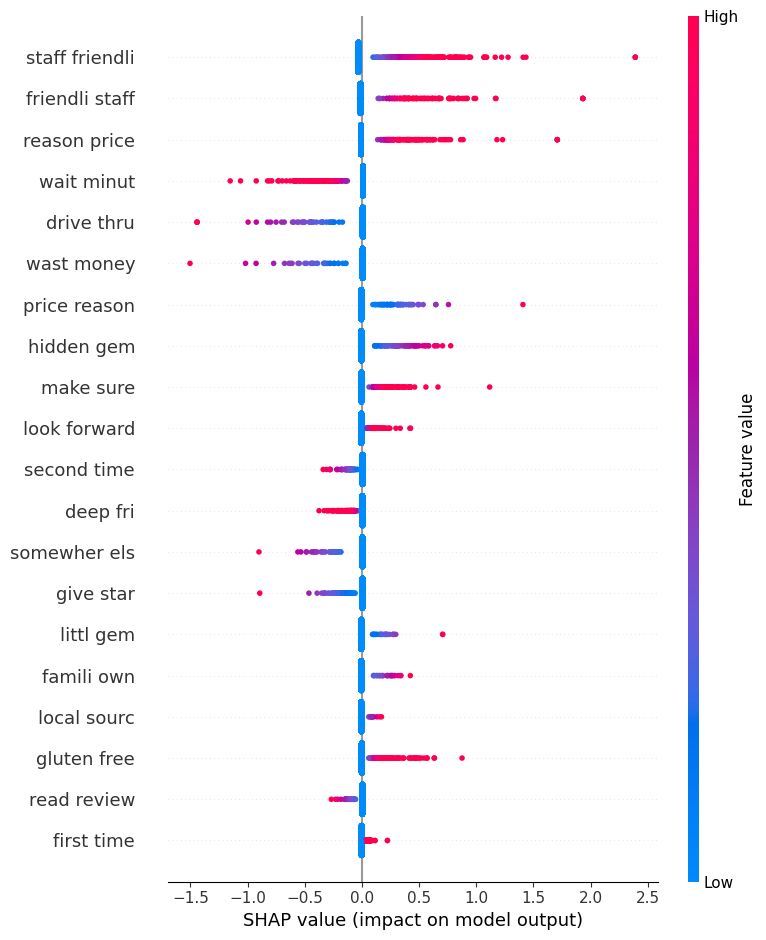

In [92]:
shap.summary_plot(shap_values, X_test_array, feature_names=vectorizer.get_feature_names())


Low values of reasonably price seem to be positive. Might indicate people are saying that it's a saving grace of the restruant?

Use SHAP to investigate individual resturant reviews

In [488]:
lowHigh.loc[3418]

index                                                            32200
business_id                                     MjYOcDz1QvPb9h6rRlpddQ
name                                                       Sushi Sugoi
address                                             2874 Calgary Trail
stars                                                              4.0
is_open                                                              0
review_count                                                        21
attributes           {'Alcohol': "u'full_bar'", 'GoodForKids': 'Tru...
categories                           Sushi Bars, Japanese, Restaurants
review_stars                                                         1
text                 The tuna sashimi they gave me in my take out o...
date                                               2014-08-05 03:46:18
cleanTokens          [the, tuna, sashimi, they, gave, me, in, my, t...
cleanText            the tuna sashimi they gave me in my take out o...
blob_p

In [317]:
findRevs = (corpus_test.reset_index())

In [491]:
ind = 7412
print(ind)
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test_array[ind,:],
    feature_names=vectorizer.get_feature_names_out()
)


7412


In [360]:
print("Positive" if y_test[8721] else "Negative", "Review:")
print(corpus_test[8721])

Positive Review:
wish another south side quality fresh portion size fair price poke check


Start Random forrest classifcation

In [518]:
# import different metrics to evaluate the classifiers
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [537]:

forest15 = RandomForestClassifier(n_estimators = 100)
forest24 = RandomForestClassifier(n_estimators = 100)

print("Fitting a random forest to labeled training data...")
# forest = forest.fit(trainDataVecs, list(albertaClean['review_stars'])[0:1000])
forest15 = forest15.fit(X_train15, y_train15)

forest24 = forest24.fit(X_train24, y_train24)


Fitting a random forest to labeled training data...


In [536]:
y_test15.value_counts()

Positive    1200
Negative    1200
Name: binRating, dtype: int64

In [538]:
print("Predicting labels for test data..")
result15 = forest15.predict(X_test15)
print(classification_report(y_test15, result15))

Predicting labels for test data..
              precision    recall  f1-score   support

    Negative       0.82      0.69      0.75      1200
    Positive       0.73      0.85      0.79      1200

    accuracy                           0.77      2400
   macro avg       0.78      0.77      0.77      2400
weighted avg       0.78      0.77      0.77      2400



In [539]:
print("Predicting labels for test data..")
result24 = forest24.predict(X_test24)
print(classification_report(y_test24, result24))

Predicting labels for test data..
              precision    recall  f1-score   support

    Negative       0.70      0.74      0.72      1200
    Positive       0.72      0.68      0.70      1200

    accuracy                           0.71      2400
   macro avg       0.71      0.71      0.71      2400
weighted avg       0.71      0.71      0.71      2400



Beginning of Time analysis of a resturant

Resources used for score calcualtion and visulization ideas:

- https://getthematic.com/insights/visualizing-customer-feedback-word-clouds/

Choose a resturant. I choose a popular Itallian resturant: Chianti Cafe & Restaurant - Old Strathcona

In [93]:
chianti = albertaClean[albertaClean['name'] == "Chianti Cafe & Restaurant - Old Strathcona"]

Organize reviews in chronological order

In [94]:
chianti = chianti.sort_values(by='date')

In [95]:
chianti['date']

15838    2008-09-29 14:34:30
15845    2008-10-20 20:26:30
15872    2008-11-01 05:16:45
15908    2009-06-06 07:54:24
15847    2009-09-02 22:02:18
                ...         
20021    2020-10-03 04:07:53
15907    2021-03-18 02:17:18
20015    2021-03-31 01:12:35
20013    2021-04-20 03:50:06
15904    2021-11-07 17:03:44
Name: date, Length: 121, dtype: object

In [96]:
chiantiText = chianti['cleanTokens']

Create key word lists to find topics in reviews

In [97]:
server = ["waitress", "minutes", "service", "staff", "freindly", "served"]
food = ["pasta", "sauce", "italian", "dishes", "pastas","salad", "delicious", "fresh", "cream", "chicken", "dish", "spicy", "cooked", "tasty", "dessert", "frenzy"]
price = ["price", "cheap", "expensive", "portion", "special", "half", "reasonably", "size", "deal", "specials", "tuesday", "mondays", "monday", "tuesdays"]

Find the number of key words in each review to assign a topic 

In [98]:

topicType = []
for i in chiantiText:
    serverCount = 0
    foodCount = 0
    priceCount = 0
    for token in i:
        if(token in server):
            serverCount+=1
            continue
        elif(token in food):
            foodCount+=1
            continue
        elif(token in price):
            priceCount+=1
    if((foodCount - 3) > serverCount and (foodCount - 3) > priceCount):
        topicType.append("dishes")
        # print(serverCount, priceCount, foodCount)
    elif(serverCount > (foodCount - 5) and serverCount > priceCount):
        topicType.append("Service")
    elif(priceCount > (foodCount - 5) and priceCount > serverCount):
        topicType.append("Price")
    else:
        if(foodCount > 0 and priceCount == 0 and serverCount == 0):
            topicType.append("dishes")
        else:
            topicType.append("Other")
        # print(serverCount, priceCount, foodCount)

pri = 0
fod = 0
ser = 0
oth = 0
for i in topicType:
    if i == "Price":
        pri+=1
        continue
    if(i == "dishes"):
        fod+=1
        continue
    if(i == "Service"):
        ser+=1
        continue
    if(i == "Other"):
        oth+=1
        continue
    
print(pri, fod, ser, oth)

39 47 27 8


In [100]:
chianti['topic'] = topicType

In [101]:
reviewStars = list(chianti['review_stars'])
polarity = list(chianti['blob_polarity'])
posNegativeScore = list(chianti['binRating'])
topicVal = list(chianti['topic'])
cumAverages = []
cumPolarityAvg = []
cumNetRatingScore = []
numDishTopics = []
numPriceTopics = []
numSerTopics = []
avg = 0
avgPol = 0
cumSum = 0
cumPol = 0
cumNet = 0
posCount = 0
negCount = 0
netRatingScore = 0
dishTops = 0
priceTops =0
serTops = 0
for i in range(len(reviewStars)):
    newVal = reviewStars[i]
    newPol = polarity[i]
    cumSum += newVal
    cumPol += newPol
    index = i + 1
    avg = cumSum / index
    avgPol = cumPol / index
    cumAverages.append(avg)
    cumPolarityAvg.append(avgPol)
    if(posNegativeScore[i] == "Positive"):
        posCount+=1
    else:
        negCount+=1
    cumNetScore = ((posCount / index) - (negCount / index)) * 100
    cumNetRatingScore.append(cumNetScore)
    if(topicVal[i] == "dishes"):
        dishTops +=1
    if(topicVal[i] == "Price"):
        priceTops +=1
    if(topicVal[i] == "Service"):
        serTops +=1
    numDishTopics.append(dishTops)
    numPriceTopics.append(priceTops)
    numSerTopics.append(serTops)


netRatingScore = ((posCount / index) - (negCount / index)) * 100

print(netRatingScore)

22.314049586776857


Find cumulative averages and scores to assin to each review in Chinatis dataframe

In [102]:
chianti['cumulativeAverageRating'] = cumAverages
chianti['cumulativeAveragePolarity'] = cumPolarityAvg
chianti['cumulativenetScore'] = cumNetRatingScore
chianti['cumulativeDishTopics'] = numDishTopics
chianti['cumulativePriceTopics'] = numPriceTopics
chianti['cumulativeSerTopics'] = numSerTopics


Investigate coorealtions between metrics

In [562]:
import seaborn  
correlation = chianti[['cumulativenetScore', 'cumulativeAverageRating', 'cumulativeAveragePolarity', 'cumulativeDishTopics', 'cumulativePriceTopics', 'cumulativeSerTopics']].corr()
# seaborn.heatmap(correlation)  
correlation.style.background_gradient (cmap = 'BrBG')  

,cumulativenetScore,cumulativeAverageRating,cumulativeAveragePolarity,cumulativeDishTopics,cumulativePriceTopics,cumulativeSerTopics
cumulativenetScore,1.000000,0.945768,0.934688,0.019780,-0.015464,0.035942
cumulativeAverageRating,0.945768,1.000000,0.942344,-0.128403,-0.169226,-0.096490
cumulativeAveragePolarity,0.934688,0.942344,1.000000,-0.020938,-0.051601,-0.007220
cumulativeDishTopics,0.019780,-0.128403,-0.020938,1.000000,0.991670,0.986473
cumulativePriceTopics,-0.015464,-0.169226,-0.051601,0.991670,1.000000,0.973856
cumulativeSerTopics,0.035942,-0.096490,-0.007220,0.986473,0.973856,1.000000


Plot correlations into a grid

In [563]:
cors = list(correlation['cumulativenetScore'][3:6])
Tops = ["Dishes", "Price", "Service"]
NumTops = [dishTops, priceTops, serTops]
corData = pd.DataFrame()
corData['topics'] = Tops
corData['importance'] = cors
corData['frequency'] = NumTops


<AxesSubplot:xlabel='importance', ylabel='frequency'>

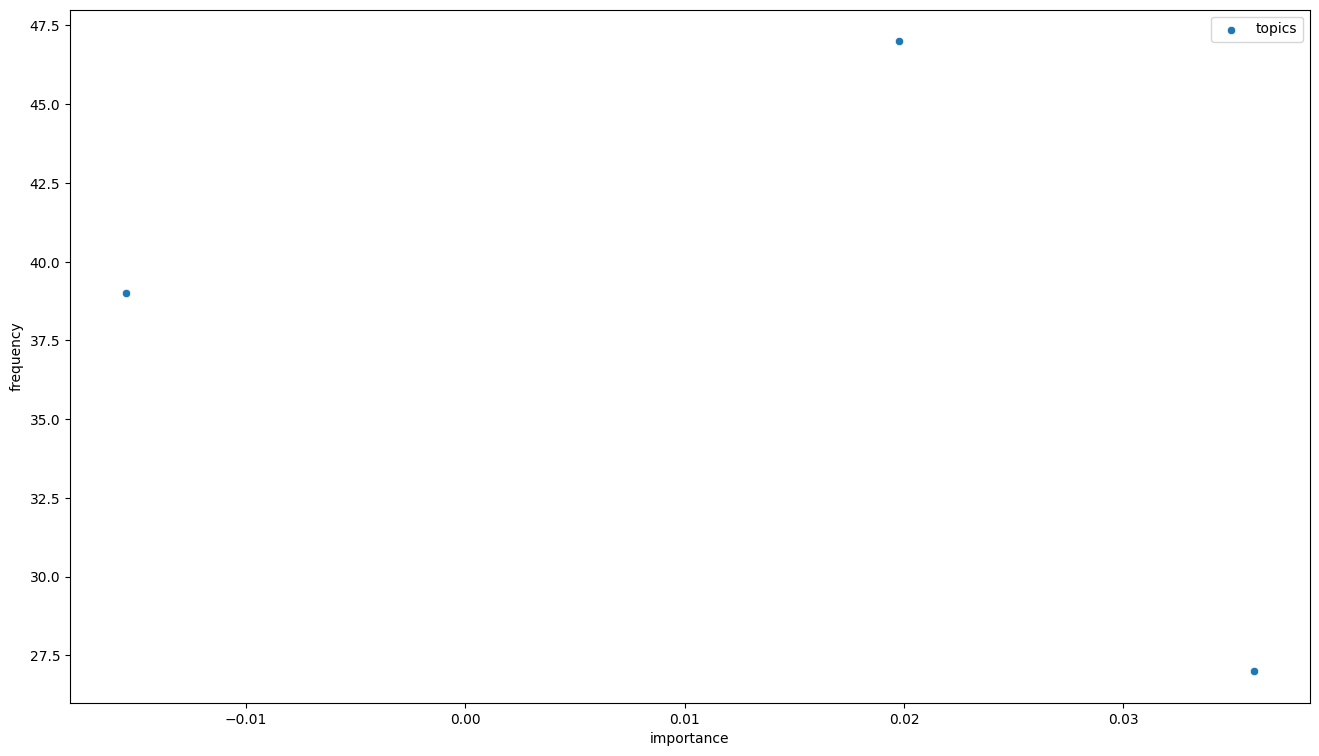

In [564]:
sns.scatterplot(data=corData, x='importance', y="frequency", label='topics')

In [221]:
from numpy import cov
from scipy.stats import pearsonr
corr, _ = pearsonr(cumNetRatingScore, numDishTopics)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: -0.015


In [222]:
from numpy import cov
from scipy.stats import pearsonr
corr, _ = pearsonr(cumNetRatingScore, numPriceTopics)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: -0.050


In [223]:
from numpy import cov
from scipy.stats import pearsonr
corr, _ = pearsonr(cumNetRatingScore, numSerTopics)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.008


Investigate another resturant, Bubba Gump Shrimp Co.

Which has a poor rating

Repeat the same process as above

In [103]:
shrimp = albertaClean[albertaClean['name']=='Bubba Gump Shrimp Co.']
shrimp

,business_id,name,address,stars,is_open,review_count,attributes,categories,review_stars,text,date,cleanTokens,cleanText,blob_polarity,blob_subjectivity,vader_score,cleanTokensNoStop,cleanTextNoStop,binRating
4748,swUT7AsP776D0XEBQrSznA,Bubba Gump Shrimp Co.,2393-8882 170 St NW,2.5,1,132,"{'RestaurantsAttire': ""u'casual'"", 'Restaurant...","Restaurants, Seafood",4,I was SUPER excited to find out a Bubba Gump w...,2018-07-17 15:11:36,"[i, was, super, excited, to, find, out, a, bub...",i was super excited to find out a bubba gump w...,0.306040,0.631554,0.9947,"[excited, find, bubba, gump, opening, anaheim,...",excit find bubba gump open anaheim locat year ...,Positive
4749,swUT7AsP776D0XEBQrSznA,Bubba Gump Shrimp Co.,2393-8882 170 St NW,2.5,1,132,"{'RestaurantsAttire': ""u'casual'"", 'Restaurant...","Restaurants, Seafood",4,It was a 2 hr wait to get in which was ok as w...,2018-07-08 05:48:00,"[it, was, a, hr, wait, to, get, in, which, was...",it was a hr wait to get in which was ok as we ...,0.664000,0.637000,0.8830,"[hr, wait, ok, able, view, many, parties, ahea...",hr wait ok abl view mani parti ahead taken soo...,Positive
4750,swUT7AsP776D0XEBQrSznA,Bubba Gump Shrimp Co.,2393-8882 170 St NW,2.5,1,132,"{'RestaurantsAttire': ""u'casual'"", 'Restaurant...","Restaurants, Seafood",2,Came here cause I've heard a lot about it and ...,2018-09-05 19:18:47,"[came, here, because, i, have, heard, a, lot, ...",came here because i have heard a lot about it ...,-0.066667,0.585000,0.9274,"[heard, lot, looks, fun, eat, shared, shrimper...",heard lot look fun eat share shrimper heaven f...,Negative
4751,swUT7AsP776D0XEBQrSznA,Bubba Gump Shrimp Co.,2393-8882 170 St NW,2.5,1,132,"{'RestaurantsAttire': ""u'casual'"", 'Restaurant...","Restaurants, Seafood",5,Honestly came here with the folks and was take...,2018-09-06 16:53:51,"[honestly, came, here, with, the, folks, and, ...",honestly came here with the folks and was take...,0.560000,0.750000,0.9663,"[honestly, folks, taken, away, nostalgia, glas...",honestli folk taken away nostalgia gla come se...,Positive
4752,swUT7AsP776D0XEBQrSznA,Bubba Gump Shrimp Co.,2393-8882 170 St NW,2.5,1,132,"{'RestaurantsAttire': ""u'casual'"", 'Restaurant...","Restaurants, Seafood",4,The shrimps were really good and the service w...,2018-07-08 23:04:01,"[the, shrimps, were, really, good, and, the, s...",the shrimps were really good and the service w...,0.263095,0.513095,0.8122,"[shrimps, okay, tip, right, away, seated, way,...",shrimp okay tip right away seat way wait anoth...,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4879,swUT7AsP776D0XEBQrSznA,Bubba Gump Shrimp Co.,2393-8882 170 St NW,2.5,1,132,"{'RestaurantsAttire': ""u'casual'"", 'Restaurant...","Restaurants, Seafood",3,First time visit for here for a date night. Se...,2018-08-15 05:13:46,"[first, time, visit, for, here, for, a, date, ...",first time visit for here for a date night ser...,0.281031,0.656433,0.9771,"[first, time, visit, date, night, waitress, kn...",first time visit date night waitress knowledg ...,Negative
4880,swUT7AsP776D0XEBQrSznA,Bubba Gump Shrimp Co.,2393-8882 170 St NW,2.5,1,132,"{'RestaurantsAttire': ""u'casual'"", 'Restaurant...","Restaurants, Seafood",2,"First off, I have had many food service and ho...",2018-07-09 19:37:31,"[first, off, i, have, had, many, food, service...",first off i have had many food service and hos...,0.116818,0.548763,0.9976,"[first, many, hospitality, jobs, pretty, under...",first mani hospit job pretti understand empath...,Negative
4881,swUT7AsP776D0XEBQrSznA,Bubba Gump Shrimp Co.,2393-8882 170 St NW,2.5,1,132,"{'RestaurantsAttire': ""u'casual'"", 'Restaurant...","Restaurants, Seafood",2,"Cool atmosphere, nice staff, had no trouble wi...",2018-08-07 19:09:06,"[cool, atmosphere, nice, staff, had, no, troub...",cool atmosphere nice staff had no trouble with...,0.053846,0.628205,0.6954,"[cool, atmosphere, staff, trouble, getting, ho...",cool atmospher staff troubl ge

Words specfic to revies for this resturant

In [105]:
food = ["shrimp", "fish", "gump", "bubba", "seafood", "chips", "calamari", "shrimpers", "cheese", 'chicken', 'mac', 'clam']
server = ["wait", "staff", "server", "waited", "hour", "order", "drinks", "freindly"]
price = ["bill", "cheap", "expensive", "reasonably", "price", "portion", "size", "deal", "specials", "special"]

In [152]:

shrimpText = shrimp['cleanTokens']

In [108]:

topicType = []
for i in shrimpText:
    serverCount = 0
    foodCount = 0
    priceCount = 0
    for token in i:
        if(token in server):
            serverCount+=1
            continue
        elif(token in food):
            foodCount+=1
            continue
        elif(token in price):
            priceCount+=1
    if((foodCount - 3) > serverCount and (foodCount - 3) > priceCount):
        topicType.append("dishes")
        # print(serverCount, priceCount, foodCount)
    elif(serverCount > (foodCount - 5) and serverCount > priceCount):
        topicType.append("Service")
    elif(priceCount > (foodCount - 5) and priceCount > serverCount):
        topicType.append("Price")
    else:
        if(foodCount > 0 and priceCount == 0 and serverCount == 0):
            topicType.append("dishes")
        else:
            topicType.append("Other")
        # print(serverCount, priceCount, foodCount)

pri = 0
fod = 0
ser = 0
oth = 0
for i in topicType:
    if i == "Price":
        pri+=1
        continue
    if(i == "dishes"):
        fod+=1
        continue
    if(i == "Service"):
        ser+=1
        continue
    if(i == "Other"):
        oth+=1
        continue
    
print(pri, fod, ser, oth)

15 28 73 20


In [109]:
shrimp['topic'] = topicType


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [110]:
reviewStars = list(shrimp['review_stars'])
polarity = list(shrimp['blob_polarity'])
posNegativeScore = list(shrimp['binRating'])
topicVal = list(shrimp['topic'])
cumAverages = []
cumPolarityAvg = []
cumNetRatingScore = []
numDishTopics = []
numPriceTopics = []
numSerTopics = []
avg = 0
avgPol = 0
cumSum = 0
cumPol = 0
cumNet = 0
posCount = 0
negCount = 0
netRatingScore = 0
dishTops = 0
priceTops =0
serTops = 0
for i in range(len(reviewStars)):
    newVal = reviewStars[i]
    newPol = polarity[i]
    cumSum += newVal
    cumPol += newPol
    index = i + 1
    avg = cumSum / index
    avgPol = cumPol / index
    cumAverages.append(avg)
    cumPolarityAvg.append(avgPol)
    if(posNegativeScore[i] == "Positive"):
        posCount+=1
    else:
        negCount+=1
    cumNetScore = ((posCount / index) - (negCount / index)) * 100
    cumNetRatingScore.append(cumNetScore)
    if(topicVal[i] == "dishes"):
        dishTops +=1
    if(topicVal[i] == "Price"):
        priceTops +=1
    if(topicVal[i] == "Service"):
        serTops +=1
    numDishTopics.append(dishTops)
    numPriceTopics.append(priceTops)
    numSerTopics.append(serTops)


netRatingScore = ((posCount / index) - (negCount / index)) * 100

print(netRatingScore)

-42.64705882352941


In [111]:
shrimp['cumulativeAverageRating'] = cumAverages
shrimp['cumulativeAveragePolarity'] = cumPolarityAvg
shrimp['cumulativenetScore'] = cumNetRatingScore
shrimp['cumulativeDishTopics'] = numDishTopics
shrimp['cumulativePriceTopics'] = numPriceTopics
shrimp['cumulativeSerTopics'] = numSerTopics


import seaborn  
correlation2 = shrimp[['cumulativenetScore', 'cumulativeAverageRating', 'cumulativeAveragePolarity', 'cumulativeDishTopics', 'cumulativePriceTopics', 'cumulativeSerTopics']].corr()
# seaborn.heatmap(correlation)  
correlation2.style.background_gradient (cmap = 'BrBG')  


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,cumulativenetScore,cumulativeAverageRating,cumulativeAveragePolarity,cumulativeDishTopics,cumulativePriceTopics,cumulativeSerTopics
cumulativenetScore,1.000000,0.972204,0.924850,-0.638419,-0.654318,-0.699127
cumulativeAverageRating,0.972204,1.000000,0.942492,-0.658377,-0.680578,-0.724377
cumulativeAveragePolarity,0.924850,0.942492,1.000000,-0.776261,-0.807555,-0.835896
cumulativeDishTopics,-0.638419,-0.658377,-0.776261,1.000000,0.963123,0.976729
cumulativePriceTopics,-0.654318,-0.680578,-0.807555,0.963123,1.000000,0.989106
cumulativeSerTopics,-0.699127,-0.724377,-0.835896,0.976729,0.989106,1.000000


In [112]:
from nltk.corpus import stopwords

nltk.download('stopwords')

language = "english"

originalStopwords = list(set(stopwords.words(language)))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Calculate net rating scores for both resturants to use in visulizations for topic impact on rating

In [113]:
priPosCount = 0
priNegCount = 0
serPosCount = 0
serNegCount = 0
dishPosCount = 0
dishNegCount = 0
otherPosCount = 0
otherNegCount = 0
for i in range(len(reviewStars)):
    if(posNegativeScore[i] == "Positive"):
        if(topicType[i] == "dishes"):
            dishPosCount+=1
        if(topicType[i] == "Service"):
            serPosCount+=1
        if(topicType[i] == "Price"):
            priPosCount+=1
        else:
            otherPosCount+=1
    else:
        if(topicType[i] == "dishes"):
            dishNegCount+=1
        if(topicType[i] == "Service"):
            serNegCount+=1
        if(topicType[i] == "Price"):
            priNegCount+=1
        else:
            otherNegCount+=1

index = len(reviewStars)
netRatingScoreService = ((serPosCount / index) - (serNegCount / index)) * 100
netRatingScorePrice = ((priPosCount / index) - (priNegCount / index)) * 100
netRatingScoreFood = ((dishPosCount / index) - (dishNegCount / index)) * 100
netRatingScoreOther = ((otherPosCount / index) - (otherNegCount / index)) * 100
print(netRatingScoreFood, netRatingScoreService, netRatingScorePrice, netRatingScoreOther)
ratingScores = pd.DataFrame()
ratingScores['topic'] = ["Dishes", "Service", "Price", "Other"]
ratingScores['netRatingScores'] = [netRatingScoreFood, netRatingScoreService, netRatingScorePrice, netRatingScoreOther]
ratingScores['percentPositive'] = [dishPosCount / (dishPosCount + dishNegCount), serPosCount / (serPosCount + serNegCount), priPosCount / (priPosCount + priNegCount), otherPosCount / (otherPosCount + otherNegCount)]
ratingScores['percentNegative'] = [dishNegCount / (dishPosCount + dishNegCount), serNegCount / (serPosCount + serNegCount), priNegCount / (priPosCount + priNegCount), otherNegCount / (otherPosCount + otherNegCount)]

ratingScores.set_index('topic')

-1.470588235294118 -27.20588235294118 -8.088235294117647 -34.55882352941177


,netRatingScores,percentPositive,percentNegative
topic,,,
Dishes,-1.470588,0.464286,0.535714
Service,-27.205882,0.246575,0.753425
Price,-8.088235,0.133333,0.866667
Other,-34.558824,0.305785,0.694215


In [114]:
ratingScores['netRatingScores'] = ratingScores['netRatingScores'].round(2)
ratingScores['percentPositive'] = (ratingScores['percentPositive'] * 100).round(2)
ratingScores['percentNegative'] = (ratingScores['percentNegative'] * 100).round(2)

In [115]:
ratingScores

,topic,netRatingScores,percentPositive,percentNegative
0,Dishes,-1.47,46.43,53.57
1,Service,-27.21,24.66,75.34
2,Price,-8.09,13.33,86.67
3,Other,-34.56,30.58,69.42


In [116]:
priPosCount = 0
priNegCount = 0
serPosCount = 0
serNegCount = 0
dishPosCount = 0
dishNegCount = 0
otherPosCount = 0
otherNegCount = 0
for i in range(len(reviewStars)):
    if(posNegativeScore[i] == "Positive"):
        if(topicType[i] == "dishes"):
            dishPosCount+=1
        if(topicType[i] == "Service"):
            serPosCount+=1
        if(topicType[i] == "Price"):
            priPosCount+=1
        else:
            otherPosCount+=1
    else:
        if(topicType[i] == "dishes"):
            dishNegCount+=1
        if(topicType[i] == "Service"):
            serNegCount+=1
        if(topicType[i] == "Price"):
            priNegCount+=1
        else:
            otherNegCount+=1

index = len(reviewStars)
netRatingScoreService = ((serPosCount / index) - (serNegCount / index)) * 100
netRatingScorePrice = ((priPosCount / index) - (priNegCount / index)) * 100
netRatingScoreFood = ((dishPosCount / index) - (dishNegCount / index)) * 100
netRatingScoreOther = ((otherPosCount / index) - (otherNegCount / index)) * 100
print(netRatingScoreFood, netRatingScoreService, netRatingScorePrice, netRatingScoreOther)
ratingScoresShrimp = pd.DataFrame()
ratingScoresShrimp['topic'] = ["Dishes", "Service", "Price", "Other"]
ratingScoresShrimp['netRatingScores'] = [netRatingScoreFood, netRatingScoreService, netRatingScorePrice, netRatingScoreOther]
ratingScoresShrimp['percentPositive'] = [dishPosCount / (dishPosCount + dishNegCount), serPosCount / (serPosCount + serNegCount), priPosCount / (priPosCount + priNegCount), otherPosCount / (otherPosCount + otherNegCount)]
ratingScoresShrimp['percentNegative'] = [dishNegCount / (dishPosCount + dishNegCount), serNegCount / (serPosCount + serNegCount), priNegCount / (priPosCount + priNegCount), otherNegCount / (otherPosCount + otherNegCount)]

ratingScoresShrimp.set_index('topic')

-1.470588235294118 -27.20588235294118 -8.088235294117647 -34.55882352941177


,netRatingScores,percentPositive,percentNegative
topic,,,
Dishes,-1.470588,0.464286,0.535714
Service,-27.205882,0.246575,0.753425
Price,-8.088235,0.133333,0.866667
Other,-34.558824,0.305785,0.694215


Shrimp resturant has negative impacts from all topics but mostly from service 

Text(0, 0.5, 'Net Score Impact on Rating')

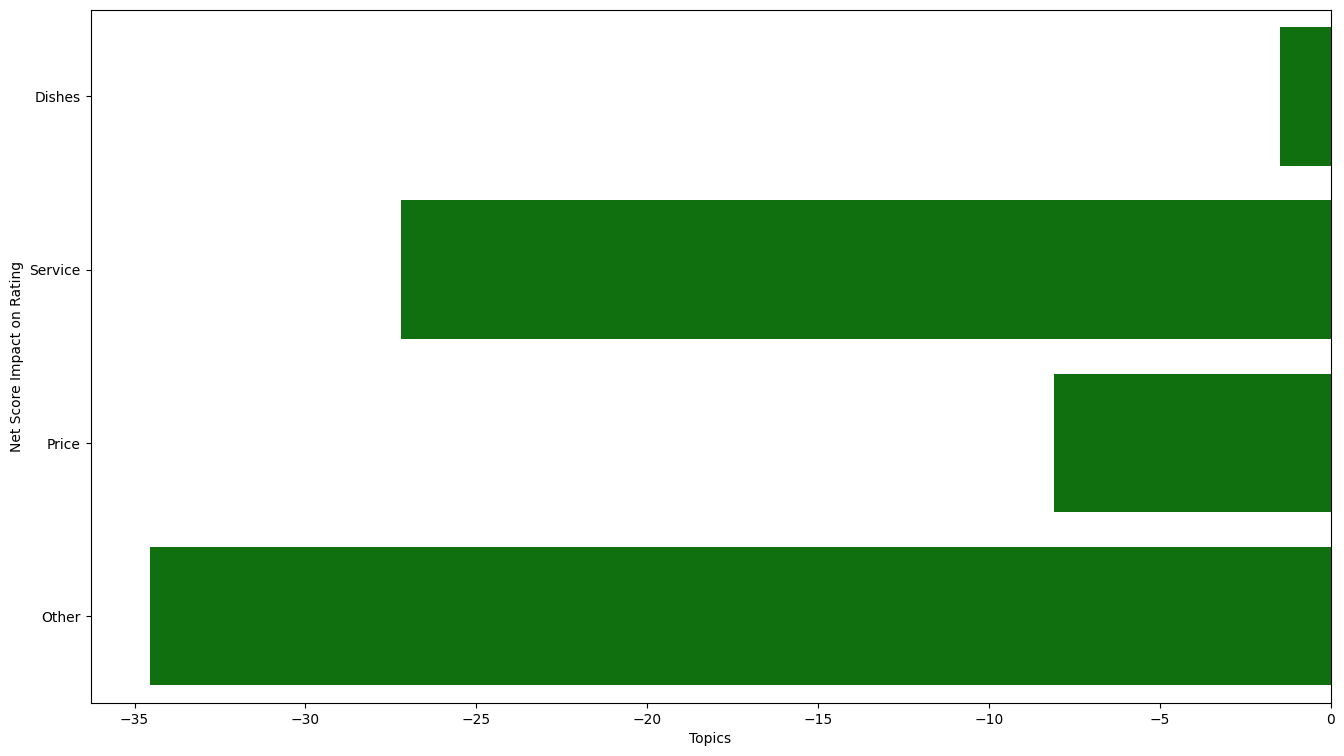

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.barplot(x = 'netRatingScores', y = 'topic', 
              data = ratingScores, 
              color = 'green')
ax.set(xlabel='Scores', ylabel='Topics')
# plt.figure(figsize=(1,1))
plt.xlabel("Topics")
plt.ylabel("Net Score Impact on Rating") 
# plt.show()

Find biggest dips in ratings

In [123]:
nums = [0,1,2]
vals = [0,0,0]
currentDif = 0
for i in range(5,len(cumAverages)):
    val1 = cumAverages[i - 2]
    val2 = cumAverages[i - 1]
    val3 = cumAverages[i]
    if(abs(val3 - val1) > currentDif):
        currentDif = abs(val3 - val1)
        print(currentDif)
        print(val1, val2, val3)
        print(i, i -1, i -2)

0.25
3.75 3.8 4.0
5 4 3
0.30158730158730185
3.857142857142857 3.875 3.5555555555555554
8 7 6
0.375
3.875 3.5555555555555554 3.5
9 8 7


Reviews that caused the dips

In [126]:
chianti.reset_index()[8:11][['date', 'review_stars', 'text','topic']]

,date,review_stars,text,topic
8,2010-10-06 17:51:58,4,I walked into this restuarant by chance as the...,Service
9,2011-01-19 23:31:56,2,"Ordered the Spaghetti Bolognese, which was a b...",dishes
10,2011-01-29 21:01:41,2,"Good service, I was staying across the road an...",Service


In [442]:
shrimp.reset_index()[7:10]

,index,business_id,name,address,stars,is_open,review_count,attributes,categories,review_stars,...,cleanTokensNoStop,cleanTextNoStop,binRating,topic,cumulativeAverageRating,cumulativeAveragePolarity,cumulativenetScore,cumulativeDishTopics,cumulativePriceTopics,cumulativeSerTopics
7,4755,swUT7AsP776D0XEBQrSznA,Bubba Gump Shrimp Co.,2393-8882 170 St NW,2.5,1,132,"{'RestaurantsAttire': ""u'casual'"", 'Restaurant...","Restaurants, Seafood",4,...,"[tried, bubbas, today, opening, day, hugh, cro...",tried bubbas today opening day hugh crowds pre...,Positive,dishes,3.875000,0.301052,50.000000,0,2,4
8,4756,swUT7AsP776D0XEBQrSznA,Bubba Gump Shrimp Co.,2393-8882 170 St NW,2.5,1,132,"{'RestaurantsAttire': ""u'casual'"", 'Restaurant...","Restaurants, Seafood",1,...,"[first, make, experience, walk, people, stop, ...",first make experience walk people stop going t...,Negative,Service,3.555556,0.271633,33.333333,0,2,5
9,4757,swUT7AsP776D0XEBQrSznA,Bubba Gump Shrimp Co.,2393-8882 170 St NW,2.5,1,132,"{'RestaurantsAttire': ""u'casual'"", 'Restaurant...","Restaurants, Seafood",3,...,"[first, time, atmosphere, server, side, experi...",first time atmosphere server side experience g...,Negative,Service,3.500000,0.269858,20.000000,0,2,6


Group the dates of reviews

In [127]:

chianti['year'] = pd.DatetimeIndex(chianti['date']).year
chianti['month'] = pd.DatetimeIndex(chianti['date']).month
# chianti['Month_Year']=chianti['date'].dt.to_period('M')

In [128]:
monYear = []
months = list(chianti['month'])
years = list(chianti['year'])
for i in range(len(months)):
    month = str(months[i])
    year = str(years[i])
    monYear.append(month + "/" + year)
    
chianti['Month_Year'] = monYear

     

In [129]:

chianti['datenoTime'] = pd.to_datetime(chianti['date']).dt.date

In [130]:
chianti[['datenoTime', 'month', 'year', 'Month_Year','cumulativeAverageRating', 'review_stars']]


,datenoTime,month,year,Month_Year,cumulativeAverageRating,review_stars
15838,2008-09-29,9,2008,9/2008,4.000000,4
15845,2008-10-20,10,2008,10/2008,4.500000,5
15872,2008-11-01,11,2008,11/2008,3.666667,2
15908,2009-06-06,6,2009,6/2009,4.000000,5
15847,2009-09-02,9,2009,9/2009,3.800000,3
...,...,...,...,...,...,...
20021,2020-10-03,10,2020,10/2020,3.564103,4
15907,2021-03-18,3,2021,3/2021,3.559322,3
20015,2021-03-31,3,2021,3/2021,3.571429,5
20013,2021-04-20,4,2021,4/2021,3.558333,2


Plot rating overtime

Text(0.5, 1.0, 'Chianti Average Rating Overtime')

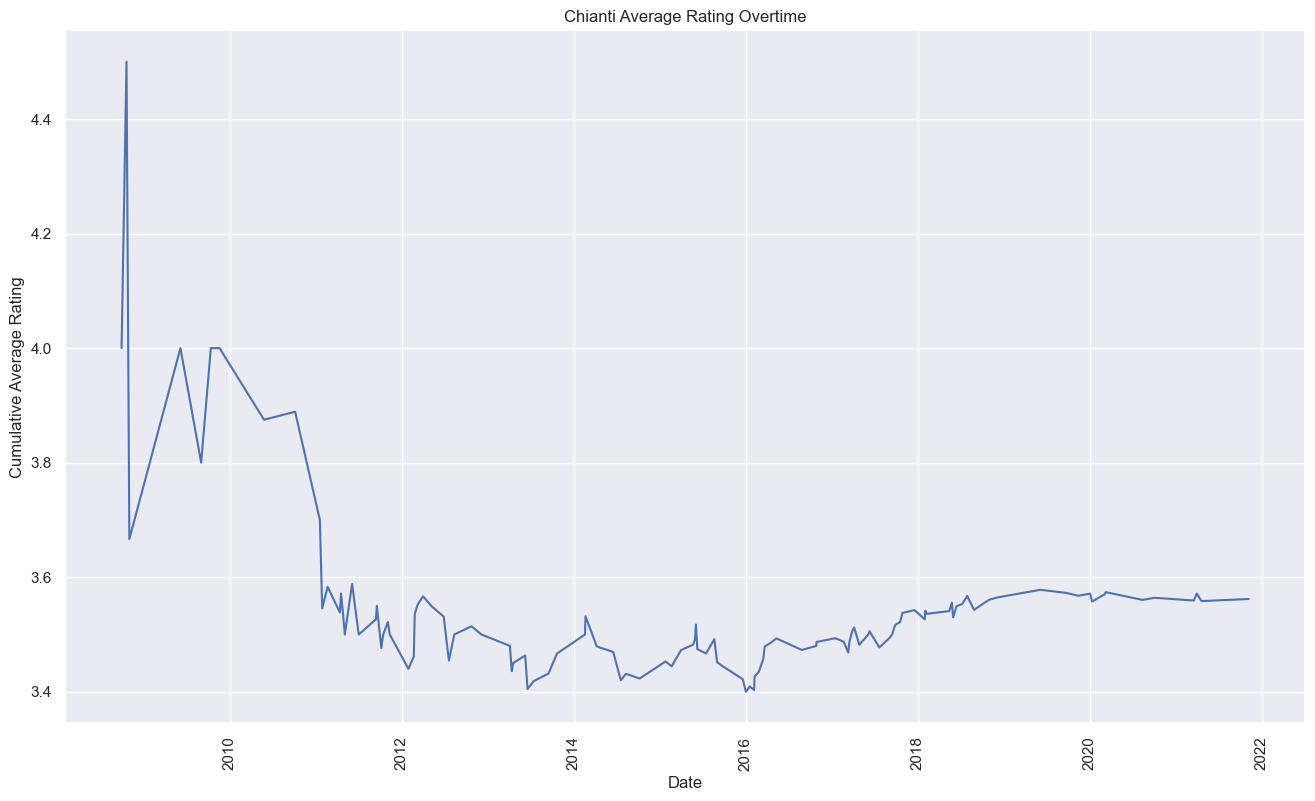

In [131]:
sns.set_theme(style="darkgrid")

sns.lineplot(data=chianti, x="datenoTime", y="cumulativeAverageRating")
# import matplotlib.dates as mdates
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

plt.xticks(rotation = 'vertical')
plt.xlabel("Date")
plt.ylabel("Cumulative Average Rating")
plt.title("Chianti Average Rating Overtime") # You can comment this line out if you don't need title

[[Text(0, 0, ''),
  Text(1, 0, ''),
  Text(2, 0, ''),
  Text(3, 0, ''),
  Text(4, 0, ''),
  Text(5, 0, ''),
  Text(6, 0, ''),
  Text(7, 0, ''),
  Text(8, 0, ''),
  Text(9, 0, ''),
  Text(10, 0, ''),
  Text(11, 0, ''),
  Text(12, 0, ''),
  Text(13, 0, ''),
  Text(14, 0, ''),
  Text(15, 0, ''),
  Text(16, 0, ''),
  Text(17, 0, ''),
  Text(18, 0, ''),
  Text(19, 0, ''),
  Text(20, 0, ''),
  Text(21, 0, ''),
  Text(22, 0, ''),
  Text(23, 0, ''),
  Text(24, 0, ''),
  Text(25, 0, ''),
  Text(26, 0, ''),
  Text(27, 0, ''),
  Text(28, 0, ''),
  Text(29, 0, ''),
  Text(30, 0, ''),
  Text(31, 0, ''),
  Text(32, 0, ''),
  Text(33, 0, ''),
  Text(34, 0, ''),
  Text(35, 0, ''),
  Text(36, 0, ''),
  Text(37, 0, ''),
  Text(38, 0, ''),
  Text(39, 0, ''),
  Text(40, 0, ''),
  Text(41, 0, ''),
  Text(42, 0, ''),
  Text(43, 0, ''),
  Text(44, 0, ''),
  Text(45, 0, ''),
  Text(46, 0, ''),
  Text(47, 0, ''),
  Text(48, 0, ''),
  Text(49, 0, ''),
  Text(50, 0, ''),
  Text(51, 0, ''),
  Text(52, 0, ''),
  T

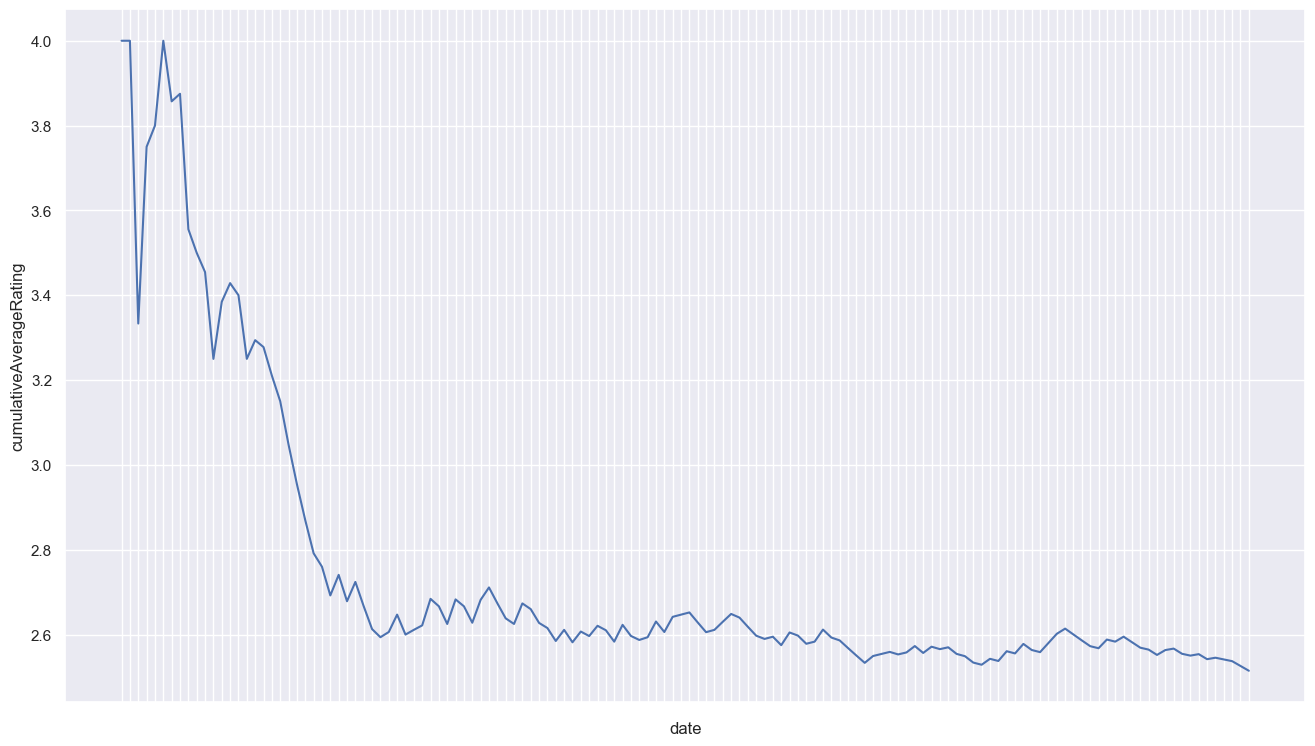

In [132]:
sns.lineplot(data=shrimp, x="date", y="cumulativeAverageRating").set(xticklabels=[])

Investigation into bi grams and words that occur frequently in reviews from resturants

In [133]:
chiantiBiGrams = []
for i in chiantiText:
    newList = []
    for word in i:
        if(word not in originalStopwords):
            newList.append(word)
        
    bis = create_ngramsList(newList, 2)
    chiantiBiGrams.append(bis)
# bg = create_ngramsList(chiantiText, 2)


In [147]:
fdistChiantiBis = FreqDist(word for rev in chiantiBiGrams for word in rev)

In [ ]:
fdistShrimp = FreqDist([word for rev in shrimpText for word in rev if word not in stopwords])
fdistShrimpBi = FreqDist(create_ngramsList([word for rev in shrimpText for word in rev if word not in stopwords], 2))
fdistShrimpTri = FreqDist(create_ngramsList([word for rev in shrimpText for word in rev if word not in stopwords], 3))

In [154]:
fdistChianti = FreqDist(word for rev in chiantiText for word in rev)

In [409]:
fdistShrimp.most_common(100)

[('shrimp', 108),
 ('wait', 76),
 ('time', 68),
 ('server', 62),
 ('ordered', 59),
 ('minutes', 53),
 ('staff', 42),
 ('gump', 41),
 ('bill', 38),
 ('fish', 37),
 ('menu', 37),
 ('experience', 37),
 ('bubba', 36),
 ('first', 34),
 ('pretty', 33),
 ('around', 33),
 ('drinks', 32),
 ('seafood', 28),
 ('much', 27),
 ('waited', 27),
 ('say', 26),
 ('seated', 26),
 ('told', 26),
 ('took', 26),
 ('hour', 25),
 ('drink', 25),
 ('fries', 24),
 ('fried', 24),
 ('finally', 24),
 ('waitress', 23),
 ('come', 23),
 ('forrest', 23),
 ('still', 22),
 ('make', 22),
 ('right', 22),
 ('way', 22),
 ('another', 22),
 ('eat', 21),
 ('kids', 21),
 ('little', 21),
 ('location', 20),
 ('fun', 20),
 ('busy', 20),
 ('give', 19),
 ('overall', 19),
 ('see', 19),
 ('long', 19),
 ('calamari', 19),
 ('stop', 19),
 ('cold', 19),
 ('since', 19),
 ('price', 19),
 ('cheese', 19),
 ('expensive', 18),
 ('manager', 18),
 ('movie', 18),
 ('bit', 17),
 ('tried', 17),
 ('take', 17),
 ('cooked', 17),
 ('wanted', 17),
 ('new', 

In [586]:
fdistChianti.most_common(100)

[('pasta', 174),
 ('good', 97),
 ('place', 74),
 ('food', 74),
 ('service', 70),
 ('great', 70),
 ('restaurant', 65),
 ('chiantis', 57),
 ('always', 56),
 ('would', 52),
 ('sauce', 52),
 ('like', 49),
 ('go', 48),
 ('one', 47),
 ('italian', 47),
 ('time', 46),
 ('really', 46),
 ('chianti', 43),
 ('get', 42),
 ('back', 41),
 ('menu', 40),
 ('order', 39),
 ('love', 36),
 ('half', 35),
 ('ordered', 34),
 ('well', 33),
 ('wine', 33),
 ('meal', 32),
 ('dishes', 32),
 ('salad', 32),
 ('never', 31),
 ('pastas', 30),
 ('delicious', 30),
 ('best', 29),
 ('definitely', 29),
 ('even', 28),
 ('nice', 28),
 ('also', 27),
 ('whyte', 26),
 ('went', 26),
 ('fresh', 25),
 ('say', 25),
 ('price', 24),
 ('cream', 24),
 ('years', 24),
 ('much', 24),
 ('full', 23),
 ('chicken', 23),
 ('edmonton', 23),
 ('made', 23),
 ('could', 23),
 ('still', 23),
 ('tuesday', 23),
 ('us', 23),
 ('monday', 22),
 ('patio', 21),
 ('dinner', 21),
 ('lunch', 21),
 ('dish', 21),
 ('large', 20),
 ('nothing', 20),
 ('old', 20),
 

In [695]:
fdistChiantiBis.most_common(100)

[('whyte ave', 18),
 ('pasta frenzy', 16),
 ('mondays tuesdays', 15),
 ('monday tuesday', 14),
 ('pasta dishes', 14),
 ('really good', 10),
 ('chocolate mousse', 9),
 ('caesar salad', 9),
 ('tomato sauce', 7),
 ('olive oil', 7),
 ('love place', 7),
 ('white wine', 7),
 ('full order', 6),
 ('gluten free', 6),
 ('next time', 6),
 ('smoked salmon', 6),
 ('cheap pasta', 6),
 ('best pasta', 6),
 ('like pasta', 6),
 ('every time', 6),
 ('coming back', 6),
 ('tuesday pasta', 6),
 ('years ago', 6),
 ('half orders', 5),
 ('large group', 5),
 ('curry sauce', 5),
 ('italian restaurant', 5),
 ('pasta dish', 5),
 ('much better', 5),
 ('good service', 5),
 ('food good', 5),
 ('service great', 5),
 ('cream sauce', 5),
 ('italian sausage', 5),
 ('pasta place', 5),
 ('great place', 5),
 ('tasted like', 5),
 ('located whyte', 4),
 ('half order', 4),
 ('service always', 4),
 ('whole wheat', 4),
 ('portion size', 4),
 ('wine list', 4),
 ('made house', 4),
 ('restaurants edmonton', 4),
 ('would give', 4),


In [432]:
fdistShrimpBi.most_common(100)

[('bubba gump shrimp', 5),
 ('shrimp mac cheese', 4),
 ('run forest run', 3),
 ('mac n cheese', 3),
 ('shrimpers heaven shrimp', 2),
 ('shrimp first time', 2),
 ('told minute wait', 2),
 ('ordered clam chowder', 2),
 ('first time establishment', 2),
 ('shrimp po boy', 2),
 ('stop forrest stop', 2),
 ('shrimp cooked dry', 2),
 ('mall wait friends', 2),
 ('something else server', 2),
 ('number text ready', 2),
 ('th time two', 2),
 ('time two hours', 2),
 ('two hours wait', 2),
 ('hours wait waitress', 2),
 ('wait waitress care', 2),
 ('waitress care taking', 2),
 ('care taking orders', 2),
 ('taking orders allow', 2),
 ('orders allow people', 2),
 ('allow people phones', 2),
 ('people phones rid', 2),
 ('waitresses lot empty', 2),
 ('lot empty tables', 2),
 ('ordered shrimpers heaven', 2),
 ('different kinds shrimp', 2),
 ('fine fish n', 2),
 ('fish n chips', 2),
 ('ordered seafood trio', 2),
 ('forest run platter', 2),
 ('deep fried seafood', 2),
 ('name wait list', 2),
 ('clam chowder